In [2]:
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models import squeezenet1_1, resnet18
from torchvision.models.squeezenet import SqueezeNet1_1_Weights
from torchvision.models.resnet import ResNet18_Weights

import pandas as pd
import numpy as np
import glob
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import itertools
from tqdm import tqdm
import pickle
import gc
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Multi-class classifier with Squeezenet

In [3]:
class MIDmodel(nn.Module):
    def __init__(self):
        super(MIDmodel, self).__init__()
        self.pretrained = squeezenet1_1(weights=SqueezeNet1_1_Weights.DEFAULT)
        self.fc1 = nn.Linear(1000, 128)
        self.fc2 = nn.Linear(128, 4)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.pretrained(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Multi-class classifier with ResNet18

In [4]:
class MIDmodel2(nn.Module):
    def __init__(self):
        super(MIDmodel2, self).__init__()
        self.pretrained = resnet18(weights = ResNet18_Weights.DEFAULT)
        self.pretrained.fc = nn.Identity()
        self.fc1 = nn.Linear(512, 4)

    def get_embeddings(self, x):
        x = self.pretrained(x)
        return x

    def forward(self, x):
        x = self.pretrained(x)
        x = self.fc1(x)
        return x

# Dataset class for the classifier

In [5]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, patients_ids, patients_df, transform=None):
        self.patients_df = patients_df[patients_df["patient_id"].isin(patients_ids)]
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.patients_df)

    def __getitem__(self, idx):
        row = self.patients_df.iloc[idx]
        # path = root_dir/patientid_examid_spot_framenumber_score.png
        path = os.path.join(self.root_dir, row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png")
        image = Image.open(path)
        label = row["score"]

        if self.transform:
            image = self.transform(image)
            
        image = transforms.ToTensor()(image)
        image = transforms.Resize((224, 224))(image)
        image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)

        return image, int(label), path

# Load the dataset and plotting information

['1052', '1069', '1050', '1017', '1048', '1067', '1051', '1047']
score
0    7888
1    7540
2    7189
3    7592
Name: patient_id, dtype: int64
['1045', '1066', '1068']
score
0    6625
1    1721
2    5535
3    3631
Name: patient_id, dtype: int64
Plot of the std of the 8-patient combinations:


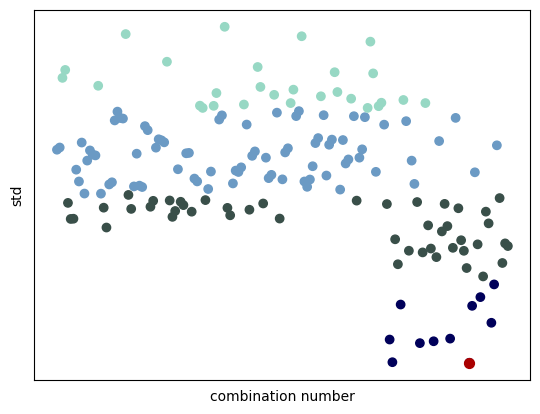

Plot of the number of frames for each score:


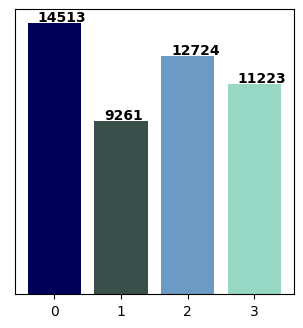

Plot of the number of frames for each score in the training set:


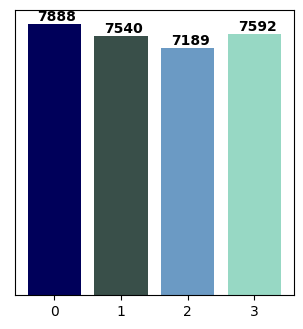

Plot of the number of frames for each score in the test set:


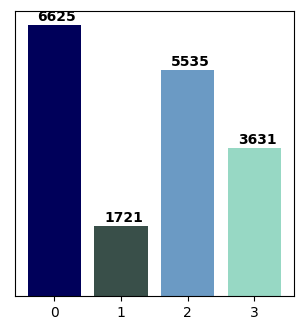

Plot of the number of frames for each patient by score:


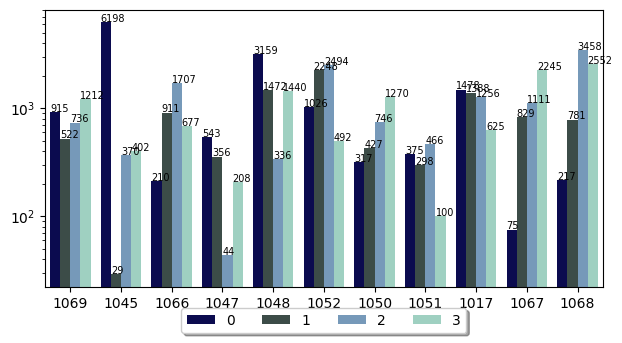

Plot of the number of frames for each spot by score:


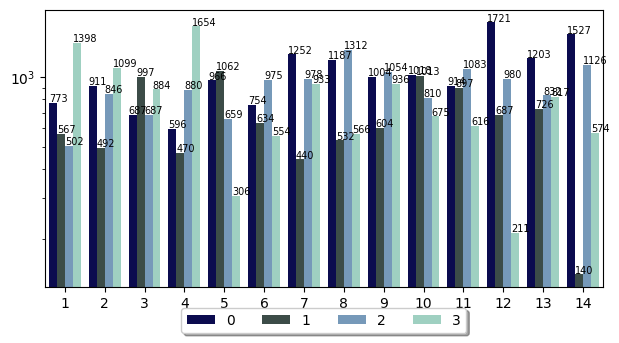

Plot of the number of frames for each spot by score for the training patients:


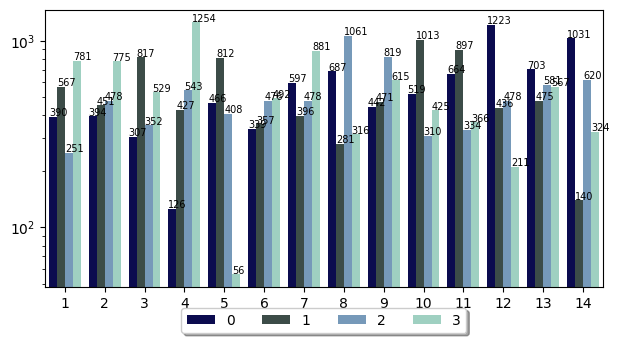

Plot of the number of frames for each spot by score for the test patients:


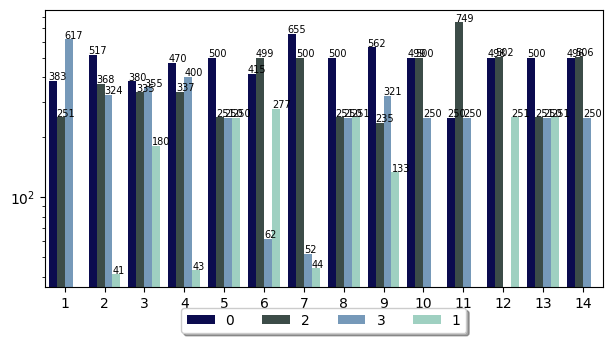

In [6]:
data_dir = "images/"
images_paths = glob.glob(f"{data_dir}*.png", recursive=True)
images_df = pd.DataFrame([path[len(data_dir):-4].split("_") for path in images_paths], columns=["patient_id", "exam_id", "spot", "frame_number", "score"])
images_df["score"] = images_df["score"].astype(str)
images_df["frame_number"] = images_df["frame_number"].astype(str)
images_df["spot"] = images_df["spot"].astype(str)
images_df["patient_id"] = images_df["patient_id"].astype(str)
images_df["exam_id"] = images_df["exam_id"].astype(str)
patients_ids = set(images_df["patient_id"])
patients_ids = list(patients_ids)

# select the 8 patients for training based on the most balanced distribution of the scores
combs = list(itertools.combinations(patients_ids, 8))
stds = []
for i, c in enumerate(combs):
    stds.append((images_df[images_df["patient_id"].isin(c)].groupby("score").count()["patient_id"].std(), i))
# sort the stds
train_patients = [x for x in combs[min(stds)[1]]]
print(train_patients)
print(images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count()["patient_id"])
test_patients = [x for x in patients_ids if x not in train_patients]
print(test_patients)
print(images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count()["patient_id"])


# plot of the std of the 8-patient combinations
custom_cmap = ListedColormap(["#00005A", "#394F49", "#6B9AC4", "#97D8C4"])
plt.scatter(np.arange(len(stds)), [x[0] for x in stds], c=[x[0] for x in stds], cmap=custom_cmap)
plt.scatter(stds[min(stds)[1]][1], stds[min(stds)[1]][0], c="#AA0000", s=50)
plt.xticks([])
plt.yticks([])
plt.xlabel("combination number")
plt.ylabel("std")
print("Plot of the std of the 8-patient combinations:")
plt.show()

colors =["#00005A", "#394F49", "#6B9AC4", "#97D8C4"]

logs = np.log(images_df.groupby("score").count()["patient_id"])
plt.bar(images_df.groupby("score").count().index, images_df.groupby("score").count()["patient_id"], color=colors)
for i, v in enumerate(images_df.groupby("score").count()["patient_id"]):
    plt.text(i - 0.25, v + 100, str(v), color='black', fontweight='bold')
plt.gcf().set_size_inches(3.6, 3.7)
plt.yticks([])
print("Plot of the number of frames for each score:")
plt.show()

#plot the number of frames for each score in the training set
plt.bar(images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count().index, images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count()["patient_id"], color=colors)
for i, v in enumerate(images_df[images_df["patient_id"].isin(train_patients)].groupby("score").count()["patient_id"]):
    plt.text(i - 0.25, v + 100, str(v), color='black', fontweight='bold')
plt.gcf().set_size_inches(3.6, 3.7)
plt.yticks([])
print("Plot of the number of frames for each score in the training set:")
plt.show()

#plot the number of frames for each score in the test set
plt.bar(images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count().index, images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count()["patient_id"], color=colors)
for i, v in enumerate(images_df[images_df["patient_id"].isin(test_patients)].groupby("score").count()["patient_id"]):
    plt.text(i - 0.25, v + 100, str(v), color='black', fontweight='bold')
plt.gcf().set_size_inches(3.6, 3.7)
plt.yticks([])
print("Plot of the number of frames for each score in the test set:")
plt.show()

# plot the number of images for each patient by score
plt.figure(figsize=(20,10))
# copy images_df in a new df called images_df3
images_df2 = images_df.copy()
images_df2 = images_df2.sort_values(by=["score"])
plt.yscale("log")
ax = sns.countplot(x="patient_id", hue="score", data=images_df2, palette=colors)
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() *(1.01)), fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.gcf().set_size_inches(7.2, 3.6)
print("Plot of the number of frames for each patient by score:")
plt.show()

# now number of images per spot per score
plt.figure(figsize=(20,10))
images_df2["spot"] = images_df2["spot"].astype(int)
images_df2 = images_df2.sort_values(by=["spot", "score"])
plt.yscale("log")
ax = sns.countplot(x="spot", hue="score", data=images_df2, palette=colors)
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() *(1.01)), fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.gcf().set_size_inches(7.2, 3.6)
print("Plot of the number of frames for each spot by score:")
plt.show()

# filter images_df to only contain the training patients
images_df2 = images_df.copy()
images_df2 = images_df2[images_df["patient_id"].isin(train_patients)]
images_df2["spot"] = images_df2["spot"].astype(int)
images_df2 = images_df2.sort_values(by=["spot", "score"])
plt.yscale("log")
ax = sns.countplot(x="spot", hue="score", data=images_df2, palette=colors)
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() *(1.01)), fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.gcf().set_size_inches(7.2, 3.6)
print("Plot of the number of frames for each spot by score for the training patients:")
plt.show()

# filter images_df to only contain the test patients
images_df2 = images_df.copy()
images_df2 = images_df2[images_df["patient_id"].isin(test_patients)]
images_df2["spot"] = images_df2["spot"].astype(int)
images_df2 = images_df2.sort_values(by=["spot", "score"])
plt.yscale("log")
ax = sns.countplot(x="spot", hue="score", data=images_df2, palette=colors)
ax.set_ylabel("")
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x(), p.get_height() *(1.01)), fontsize=7)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4)
plt.gcf().set_size_inches(7.2, 3.6)
print("Plot of the number of frames for each spot by score for the test patients:")
plt.show()


# Train and Test functions

In [7]:
def train_model(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels, _ in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects/ len(dataloader.dataset)
    return epoch_loss, epoch_acc

def test_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels, _ in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects / len(dataloader.dataset)
    return epoch_loss, epoch_acc


# Create the Dataset to train the classifier

In [8]:
data_dir = "images/"
num_epochs = 16
learning_rate = 0.00001
batch_size = 8

transformations = transforms.Compose([
    transforms.RandomApply([transforms.RandomAffine(degrees=15, translate=(0, 0.15), scale=(0.55, 1.45), shear=4.5)], p=1/2),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.45, contrast=0.45, saturation=0.45, hue=0.45)], p=1/2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.75))], p=1/2),
    transforms.RandomApply([transforms.RandomHorizontalFlip(p=0.5)], p=1/2),
    ])

model = MIDmodel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

train_dataset = ImageDataset(data_dir, train_patients, images_df, transformations)

test_images_df = images_df[images_df["patient_id"].isin(test_patients)]
# get only 800 images per score in the test set to have a balanced test set and speed up the training
test_images_df = test_images_df.groupby("score").apply(lambda x: x.sample(200)).reset_index(drop=True)
# test_dataset = ImageDataset(data_dir, test_patients, test_images_df)
test_dataset = ImageDataset(data_dir, test_patients, images_df)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [48]:
results_train = []
results_test = []

best_acc = 0.0
for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    results_train.append([train_loss, train_acc])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(model, test_dataloader, criterion, device)
    results_test.append([test_loss, test_acc])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/MIDmodel.pt")

best_acc1 = best_acc
torch.save(model.state_dict(), f"models/MIDmodel_last.pt")

Epoch 0


  0%|          | 3/3777 [00:01<21:51,  2.88it/s]


KeyboardInterrupt: 

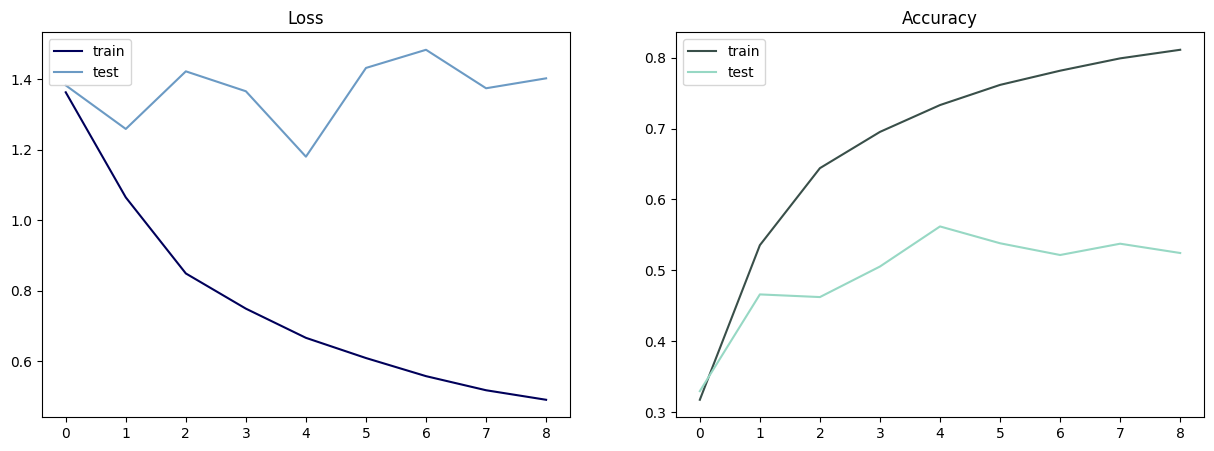

4


In [ ]:
results_testA = [[x[0], x[1].item()] for x in results_test]
results_trainA = [[x[0], x[1].item()] for x in results_train]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
colors =["#00005A", "#394F49", "#6B9AC4", "#97D8C4"]
ax[0].plot(np.array(results_trainA)[:, 0], label="train", color=colors[0])
ax[0].plot(np.array(results_testA)[:, 0], label="test", color=colors[2])
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(np.array(results_trainA)[:, 1], label="train", color=colors[1])
ax[1].plot(np.array(results_testA)[:, 1], label="test", color=colors[3])
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

# print the i where  test loss is minimized
print(np.argmin(np.array(results_testA)[:, 0]))

100%|██████████| 400/400 [00:36<00:00, 10.87it/s]


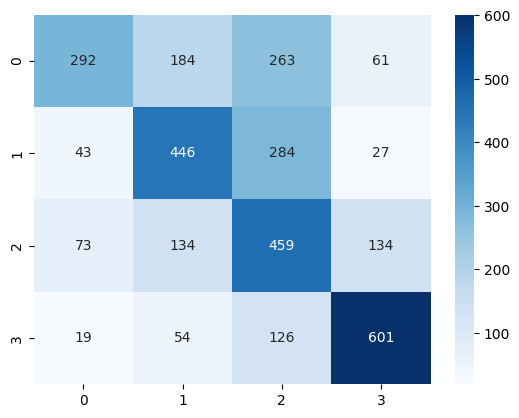

In [ ]:
model = MIDmodel()
model.load_state_dict(torch.load("models/MIDmodel.pt"))
model = model.to(device)
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels, _ in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()



# Train ResNet18

In [ ]:
model = MIDmodel2()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
results_train = []
results_test = []
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(model, train_dataloader, optimizer, criterion, device)
    results_train.append([train_loss, train_acc])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(model, test_dataloader, criterion, device)
    results_test.append([test_loss, test_acc])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    # if current test accuracy is better than previous best, save the model
    if test_acc > best_acc:
        best_acc = test_acc
        torch.save(model.state_dict(), f"models/MIDmodel2.pt")
best_acc2 = best_acc
torch.save(model.state_dict(), f"models/MIDmodel2_last.pt")


Epoch 0


100%|██████████| 3777/3777 [20:08<00:00,  3.13it/s]


Training Loss: 0.7485 Training Accuracy: 0.6984


100%|██████████| 400/400 [00:39<00:00, 10.25it/s]


Test Loss: 1.3264 Test Accuracy: 0.5188
Epoch 1


100%|██████████| 3777/3777 [19:46<00:00,  3.18it/s]


Training Loss: 0.4539 Training Accuracy: 0.8295


100%|██████████| 400/400 [00:39<00:00, 10.22it/s]


Test Loss: 1.1518 Test Accuracy: 0.6031
Epoch 2


100%|██████████| 3777/3777 [19:39<00:00,  3.20it/s]


Training Loss: 0.3582 Training Accuracy: 0.8677


100%|██████████| 400/400 [00:39<00:00, 10.02it/s]


Test Loss: 1.3211 Test Accuracy: 0.5428
Epoch 3


100%|██████████| 3777/3777 [19:49<00:00,  3.17it/s]


Training Loss: 0.3038 Training Accuracy: 0.8887


100%|██████████| 400/400 [00:39<00:00, 10.05it/s]


Test Loss: 1.3771 Test Accuracy: 0.5550
Epoch 4


100%|██████████| 3777/3777 [19:53<00:00,  3.16it/s]


Training Loss: 0.2715 Training Accuracy: 0.9007


100%|██████████| 400/400 [00:40<00:00,  9.91it/s]


Test Loss: 1.3991 Test Accuracy: 0.5334
Epoch 5


100%|██████████| 3777/3777 [19:44<00:00,  3.19it/s]


Training Loss: 0.2444 Training Accuracy: 0.9112


100%|██████████| 400/400 [00:41<00:00,  9.65it/s]


Test Loss: 1.6543 Test Accuracy: 0.5316
Epoch 6


100%|██████████| 3777/3777 [19:29<00:00,  3.23it/s]


Training Loss: 0.2221 Training Accuracy: 0.9200


100%|██████████| 400/400 [00:44<00:00,  9.00it/s]


Test Loss: 1.5222 Test Accuracy: 0.5644
Epoch 7


100%|██████████| 3777/3777 [19:31<00:00,  3.22it/s]


Training Loss: 0.2075 Training Accuracy: 0.9254


100%|██████████| 400/400 [00:43<00:00,  9.15it/s]


Test Loss: 1.5660 Test Accuracy: 0.5353
Epoch 8


100%|██████████| 3777/3777 [19:30<00:00,  3.23it/s]


Training Loss: 0.1893 Training Accuracy: 0.9313


100%|██████████| 400/400 [00:39<00:00, 10.11it/s]


Test Loss: 1.4173 Test Accuracy: 0.5662
Epoch 9


100%|██████████| 3777/3777 [19:33<00:00,  3.22it/s]


Training Loss: 0.1779 Training Accuracy: 0.9361


100%|██████████| 400/400 [00:43<00:00,  9.19it/s]


Test Loss: 1.6126 Test Accuracy: 0.5619
Epoch 10


100%|██████████| 3777/3777 [19:35<00:00,  3.21it/s]


Training Loss: 0.1665 Training Accuracy: 0.9387


100%|██████████| 400/400 [00:43<00:00,  9.11it/s]


Test Loss: 1.7252 Test Accuracy: 0.5147
Epoch 11


100%|██████████| 3777/3777 [19:39<00:00,  3.20it/s]


Training Loss: 0.1543 Training Accuracy: 0.9437


100%|██████████| 400/400 [00:43<00:00,  9.28it/s]


Test Loss: 1.6628 Test Accuracy: 0.5372
Epoch 12


100%|██████████| 3777/3777 [19:32<00:00,  3.22it/s]


Training Loss: 0.1543 Training Accuracy: 0.9421


100%|██████████| 400/400 [00:40<00:00,  9.80it/s]


Test Loss: 1.9398 Test Accuracy: 0.5241
Epoch 13


  2%|▏         | 75/3777 [00:23<19:08,  3.22it/s]


KeyboardInterrupt: 

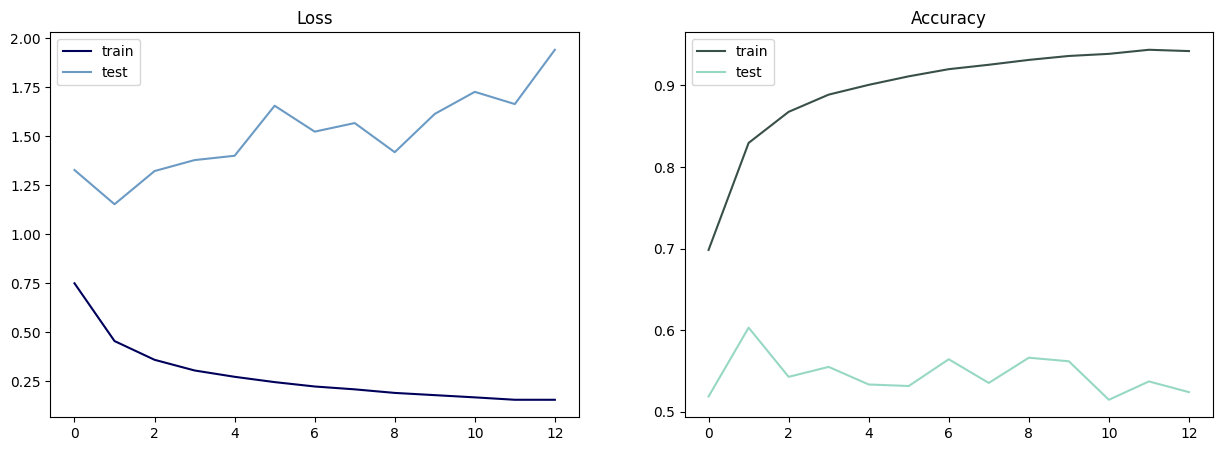

1


100%|██████████| 400/400 [00:38<00:00, 10.45it/s]


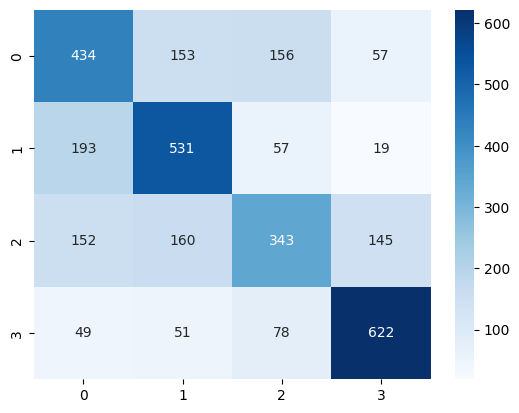

In [ ]:
results_testA = [[x[0], x[1].item()] for x in results_test]
results_trainA = [[x[0], x[1].item()] for x in results_train]
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(np.array(results_trainA)[:, 0], label="train", color=colors[0])
ax[0].plot(np.array(results_testA)[:, 0], label="test", color=colors[2])
ax[0].set_title("Loss")
ax[0].legend()
ax[1].plot(np.array(results_trainA)[:, 1], label="train", color=colors[1])
ax[1].plot(np.array(results_testA)[:, 1], label="test", color=colors[3])
ax[1].set_title("Accuracy")
ax[1].legend()
plt.show()

# print the i where  test loss is minimized
print(np.argmin(np.array(results_testA)[:, 0]))

model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model = model.to(device)
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels, _ in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

100%|██████████| 2189/2189 [03:38<00:00, 10.00it/s]

Accuracy:  0.563270899954317


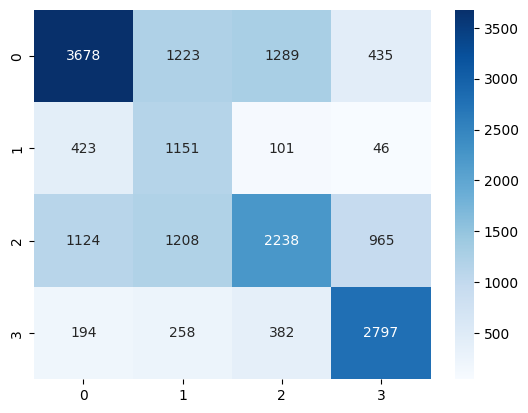

In [44]:
# cm on the entire test set
model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model = model.to(device)
model.eval()

y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels, _ in tqdm(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Accuracy: ", accuracy_score(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# Classifier to predict if the confidence is high enough, created on the train dataset

In [ ]:
# load the last model
best_acc1 = 0.5619
best_acc2 = 0.6031
if best_acc1 > best_acc2:
    print("Loaded MIDmodel.pt")
    model = MIDmodel()
    model.load_state_dict(torch.load("models/MIDmodel.pt"))
else:
    print("Loaded MIDmodel2.pt")
    model = MIDmodel2()
    model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

test_dataset = ImageDataset(data_dir, test_patients, images_df)

correct_preds = pd.DataFrame(columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])
wrong_preds = pd.DataFrame(columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])

for i in tqdm(range(len(test_dataset))):
    img, label, path = test_dataset[i]
    img = img.unsqueeze(0)
    img = img.to(device)
    output = model(img)
    sm = nn.Softmax(dim=1)
    sm = sm(output)
    sm = sm.cpu().detach().numpy()
    sm = sm[0]
    if torch.argmax(output) == label:
        correct_preds = pd.concat([correct_preds, pd.DataFrame([[path, label, torch.argmax(output).cpu().detach().numpy(), sm[0], sm[1], sm[2], sm[3]]], columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])])
    else:
        wrong_preds = pd.concat([wrong_preds, pd.DataFrame([[path, label, torch.argmax(output).cpu().detach().numpy(), sm[0], sm[1], sm[2], sm[3]]], columns=["path", "true", "predicted", "sm0", "sm1", "sm2", "sm3"])])

correct_preds.to_csv("data/correct_preds_test.csv", index=False)
wrong_preds.to_csv("data/wrong_preds_test.csv", index=False)


Loaded MIDmodel2.pt


100%|██████████| 17512/17512 [05:15<00:00, 55.47it/s]


In [ ]:
correct_preds = pd.read_csv("data/correct_preds_test.csv")
wrong_preds = pd.read_csv("data/wrong_preds_test.csv")

correct_preds["correct"] = 1
wrong_preds["correct"] = 0

preds_total = pd.concat([correct_preds, wrong_preds])
preds_total.to_csv("data/values_test.csv", index=False)

# DL model to binary classify the behaviour

In [14]:
class MIDbinary(nn.Module):
    def __init__(self):
        super(MIDbinary, self).__init__()
        self.fc1 = nn.Linear(4, 2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x
    
class BinaryDataset(Dataset):
    def __init__(self, preds):
        self.preds = preds

    def __len__(self):
        return len(self.preds)

    def __getitem__(self, idx):
        label = self.preds.iloc[idx]["correct"]
        sms = self.preds.iloc[idx][["sm0", "sm1", "sm2", "sm3"]]
        sms = torch.tensor(list(sms.values), dtype=torch.float32)
        return sms, int(label), self.preds.iloc[idx]["path"]

In [20]:
binary_model = MIDbinary()
binary_model = binary_model.to(device)
criterion = nn.CrossEntropyLoss()
learning_rate = 0.00001
optimizer = optim.SGD(binary_model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(binary_model.parameters(), lr=learning_rate)
train_values = pd.read_csv("data/values_train.csv")
test_values = pd.read_csv("data/values_test.csv")

train_dataset_bin = BinaryDataset(train_values)
test_dataset_bin = BinaryDataset(test_values)
train_dataloader_bin = DataLoader(train_dataset_bin, batch_size=batch_size, shuffle=True)
test_dataloader_bin = DataLoader(test_dataset_bin, batch_size=batch_size, shuffle=True)

results_train = []
results_test = []
num_epochs = 20
max_test = 0

for epoch in range(num_epochs):
    print(f"Epoch {epoch}")
    train_loss, train_acc = train_model(binary_model, train_dataloader_bin, optimizer, criterion, device)
    results_train.append([train_loss, train_acc.item()])
    print(f"Training Loss: {train_loss:.4f} Training Accuracy: {train_acc:.4f}")
    test_loss, test_acc = test_model(binary_model, test_dataloader_bin, criterion, device)
    results_test.append([test_loss, test_acc.item()])
    print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")
    if( epoch > 0  and (results_train[len(results_train)-1][0] >=  results_train[len(results_train)-2][0])):
        print(results_train[len(results_train)-1], results_train[len(results_train)-2])
        print("Overfitting")
        break
    if epoch % 2 == 0:
        learning_rate = learning_rate/2
        optimizer = optim.SGD(binary_model.parameters(), lr=learning_rate)
    if test_acc > max_test:
        max_test = test_acc
        torch.save(binary_model.state_dict(), f"models/binary_model.pt")

torch.save(binary_model.state_dict(), f"models/binary_model_last.pt")

print("Train: ", results_train)
print("Test: ", results_test)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot([i[0] for i in results_train])
axs[0, 0].set_title("Train Loss")
axs[0, 1].plot([i[1] for i in results_train])
axs[0, 1].set_title("Train Accuracy")
axs[1, 0].plot([i[0] for i in results_test])
axs[1, 0].set_title("Test Loss")
axs[1, 1].plot([i[1] for i in results_test])
axs[1, 1].set_title("Test Accuracy")
plt.show()

Epoch 0


100%|██████████| 3777/3777 [00:17<00:00, 218.66it/s]


Training Loss: 0.7764 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:08<00:00, 244.66it/s]


Test Loss: 0.7209 Test Accuracy: 0.4367
Epoch 1


100%|██████████| 3777/3777 [00:17<00:00, 220.25it/s]


Training Loss: 0.7725 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:09<00:00, 237.99it/s]


Test Loss: 0.7200 Test Accuracy: 0.4367
Epoch 2


100%|██████████| 3777/3777 [00:16<00:00, 229.94it/s]


Training Loss: 0.7700 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:08<00:00, 271.35it/s]


Test Loss: 0.7191 Test Accuracy: 0.4367
Epoch 3


100%|██████████| 3777/3777 [00:17<00:00, 218.53it/s]


Training Loss: 0.7681 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:08<00:00, 245.23it/s]


Test Loss: 0.7187 Test Accuracy: 0.4367
Epoch 4


100%|██████████| 3777/3777 [00:16<00:00, 226.78it/s]


Training Loss: 0.7669 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:09<00:00, 228.69it/s]


Test Loss: 0.7183 Test Accuracy: 0.4367
Epoch 5


100%|██████████| 3777/3777 [00:16<00:00, 227.82it/s]


Training Loss: 0.7660 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:09<00:00, 238.38it/s]


Test Loss: 0.7181 Test Accuracy: 0.4367
Epoch 6


100%|██████████| 3777/3777 [00:16<00:00, 222.19it/s]


Training Loss: 0.7654 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:08<00:00, 263.16it/s]


Test Loss: 0.7179 Test Accuracy: 0.4367
Epoch 7


100%|██████████| 3777/3777 [00:16<00:00, 230.71it/s]


Training Loss: 0.7649 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:08<00:00, 250.11it/s]


Test Loss: 0.7178 Test Accuracy: 0.4367
Epoch 8


100%|██████████| 3777/3777 [00:17<00:00, 220.93it/s]


Training Loss: 0.7646 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:08<00:00, 269.70it/s]


Test Loss: 0.7177 Test Accuracy: 0.4367
Epoch 9


100%|██████████| 3777/3777 [00:16<00:00, 226.25it/s]


Training Loss: 0.7644 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:07<00:00, 286.37it/s]


Test Loss: 0.7176 Test Accuracy: 0.4367
Epoch 10


100%|██████████| 3777/3777 [00:16<00:00, 222.25it/s]


Training Loss: 0.7642 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:07<00:00, 274.14it/s]


Test Loss: 0.7176 Test Accuracy: 0.4367
Epoch 11


100%|██████████| 3777/3777 [00:17<00:00, 220.39it/s]


Training Loss: 0.7641 Training Accuracy: 0.1892


100%|██████████| 2189/2189 [00:08<00:00, 245.07it/s]


Test Loss: 0.7176 Test Accuracy: 0.4367
Epoch 12


100%|██████████| 3777/3777 [00:17<00:00, 218.30it/s]


Training Loss: 0.7641 Training Accuracy: 0.1892


 83%|████████▎ | 1807/2189 [00:07<00:01, 253.85it/s]


KeyboardInterrupt: 

In [ ]:
if best_acc1 > best_acc2:
    model = MIDmodel()
    model.load_state_dict(torch.load("models/MIDmodel.pt"))
else:
    model = MIDmodel2()
    model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

binary_model = MIDbinary()
binary_model.load_state_dict(torch.load("models/binary_model.pt"))
binary_model.to(device)
binary_model.eval()

usefulcount = 0
uselesscount = 0
for i in tqdm(range(len(test_dataset))):
    img, label, _ = test_dataset[i]
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model(img)
    sm = torch.nn.functional.softmax(output, dim=1)
    binary_output = binary_model(sm)
    predicted_label = torch.argmax(output).cpu().detach().numpy()
    predicted_binary = torch.argmax(binary_output).cpu().detach().numpy()
    # print(f"True label: {label} Predicted label: {predicted_label} Binary output: {predicted_binary}")
    if((predicted_label != label and predicted_binary == 0) or (predicted_label == label and predicted_binary == 1)):
        usefulcount += 1
    else:
        uselesscount += 1

print("Accuracy of the binary model on test set:")
print("Useful: ", usefulcount)
print("Useful[%]: ", usefulcount/(usefulcount+uselesscount)*100)
print("Useless: ", uselesscount)
print("Useless[%]: ", uselesscount/(usefulcount+uselesscount)*100)

100%|██████████| 17512/17512 [04:12<00:00, 69.30it/s]

Accuracy of the binary model on test set:
Useful:  9573
Useful[%]:  54.66537231612608
Useless:  7939
Useless[%]:  45.33462768387391


# Support Vector Classifier

In [64]:
# load the values
pred_train = pd.read_csv("data/values_train.csv")
pred_test = pd.read_csv("data/values_test.csv")


pred_train = pred_train.drop("path", axis=1)
pred_test = pred_test.drop("path", axis=1)
pred_train = pred_train.drop("true", axis=1)
pred_test = pred_test.drop("true", axis=1)
pred_test = pred_test.drop("predicted", axis=1)
pred_train = pred_train.drop("predicted", axis=1)

# we need preds_train and preds_test to have 50% of correct = 1 and 50% of correct = 0 to balance the dataset
print("Before balancing:")
print("Train correct = 1: ", len(pred_train[pred_train["correct"] == 1]))
print("Train correct = 0: ", len(pred_train[pred_train["correct"] == 0]))
print("Test correct = 1: ", len(pred_test[pred_test["correct"] == 1]))
print("Test correct = 0: ", len(pred_test[pred_test["correct"] == 0]))

preds_tmp = pred_train[pred_train["correct"] == 0]
preds_tmp = pd.concat([preds_tmp, pred_train[pred_train["correct"] == 1][:len(preds_tmp)]])
pred_train = preds_tmp
print("\nAfter balancing:")
print("Train correct = 1: ", len(pred_train[pred_train["correct"] == 1]))
print("Train correct = 0: ", len(pred_train[pred_train["correct"] == 0]))


X_train = pred_train.drop("correct", axis=1)
y_train = pred_train["correct"]
X_test = pred_test.drop("correct", axis=1)
y_test = pred_test["correct"]

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))
pickle.dump(clf, open("models/svc.pkl", "wb"))


Before balancing:
Train correct = 1:  24493
Train correct = 0:  5716
Test correct = 1:  9865
Test correct = 0:  7647

After balancing:
Train correct = 1:  5716
Train correct = 0:  5716
Accuracy:  0.5633851073549566


# 4 SVCs

9008 1623 7385
7472 2102 5370
5686 916 4770
8043 1075 6968
5420 1741 3679
3841 2690 1151
4008 1770 2238
4243 1446 2797
1832 916 916
0.6195414847161572
0.5120087336244541
0.4759825327510917
0.6544759825327511
0.6195414847161572


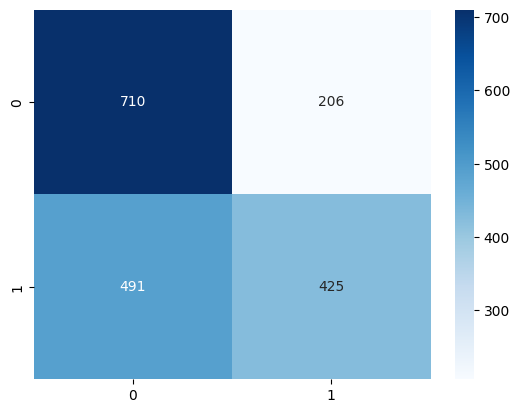

0.5120087336244541


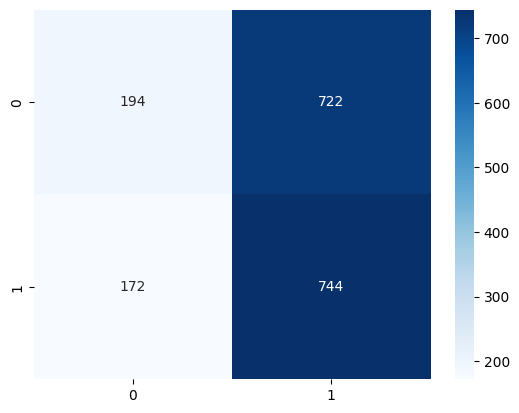

0.4759825327510917


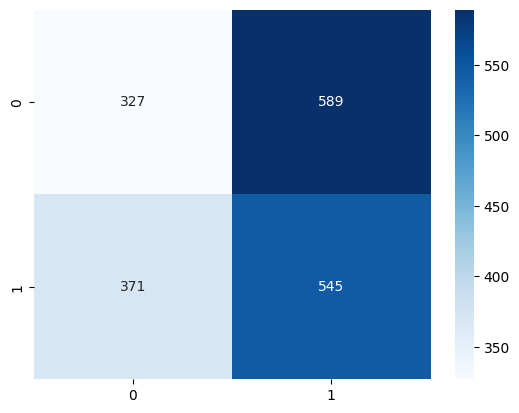

0.6544759825327511


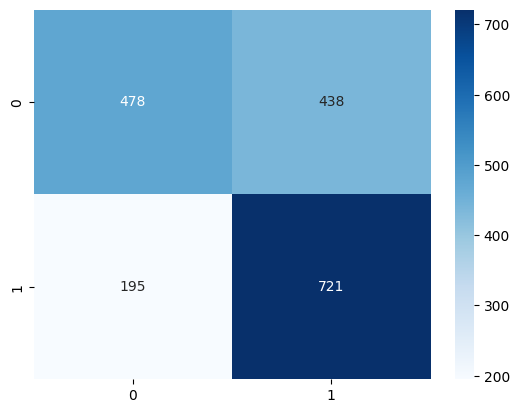

avg: 0.5655021834061136


In [41]:
# create 4 svc, one for each class
clf1 = SVC()
clf2 = SVC()
clf3 = SVC()
clf4 = SVC()

pred_train = pd.read_csv("data/values_train.csv")
pred_test = pd.read_csv("data/values_test.csv")

# these dataframe have the path, true label, predicted label and the values of the 4 softmax outputs
pred_train = pred_train.drop("path", axis=1)
pred_test = pred_test.drop("path", axis=1)
# we now want to create 4 different datasets, one for each class, and they have to be balanced
n = 916
# create the 4 datasets
pred_train0 = pred_train[pred_train["predicted"] == 0]
print(len(pred_train0), len(pred_train0[pred_train0["correct"] == 0]), len(pred_train0[pred_train0["correct"] == 1]))
pred_train1 = pred_train[pred_train["predicted"] == 1]
print(len(pred_train1), len(pred_train1[pred_train1["correct"] == 0]), len(pred_train1[pred_train1["correct"] == 1]))
pred_train2 = pred_train[pred_train["predicted"] == 2]
print(len(pred_train2), len(pred_train2[pred_train2["correct"] == 0]), len(pred_train2[pred_train2["correct"] == 1]))
pred_train3 = pred_train[pred_train["predicted"] == 3]
print(len(pred_train3), len(pred_train3[pred_train3["correct"] == 0]), len(pred_train3[pred_train3["correct"] == 1]))

pred_test0 = pred_test[pred_test["predicted"] == 0]
print(len(pred_test0), len(pred_test0[pred_test0["correct"] == 0]), len(pred_test0[pred_test0["correct"] == 1]))
pred_test1 = pred_test[pred_test["predicted"] == 1]
print(len(pred_test1), len(pred_test1[pred_test1["correct"] == 0]), len(pred_test1[pred_test1["correct"] == 1]))
pred_test2 = pred_test[pred_test["predicted"] == 2]
print(len(pred_test2), len(pred_test2[pred_test2["correct"] == 0]), len(pred_test2[pred_test2["correct"] == 1]))
pred_test3 = pred_test[pred_test["predicted"] == 3]
print(len(pred_test3), len(pred_test3[pred_test3["correct"] == 0]), len(pred_test3[pred_test3["correct"] == 1]))

# create the 4 balanced datasets, getting 500 entries for correct = 0 and 500 entries for correct = 1 for each class
pred_train0 = pd.concat([pred_train0[pred_train0["correct"] == 0][:n], pred_train0[pred_train0["correct"] == 1][:n]])
print(len(pred_train0), len(pred_train0[pred_train0["correct"] == 0]), len(pred_train0[pred_train0["correct"] == 1]))

pred_train1 = pd.concat([pred_train1[pred_train1["correct"] == 0][:n], pred_train1[pred_train1["correct"] == 1][:n]])
pred_train2 = pd.concat([pred_train2[pred_train2["correct"] == 0][:n], pred_train2[pred_train2["correct"] == 1][:n]])
pred_train3 = pd.concat([pred_train3[pred_train3["correct"] == 0][:n], pred_train3[pred_train3["correct"] == 1][:n]])

pred_test0 = pd.concat([pred_test0[pred_test0["correct"] == 0][:n], pred_test0[pred_test0["correct"] == 1][:n]])
pred_test1 = pd.concat([pred_test1[pred_test1["correct"] == 0][:n], pred_test1[pred_test1["correct"] == 1][:n]])
pred_test2 = pd.concat([pred_test2[pred_test2["correct"] == 0][:n], pred_test2[pred_test2["correct"] == 1][:n]])
pred_test3 = pd.concat([pred_test3[pred_test3["correct"] == 0][:n], pred_test3[pred_test3["correct"] == 1][:n]])

# create the 4 datasets
X_train0 = pred_train0.drop("correct", axis=1)
y_train0 = pred_train0["correct"]
X_test0 = pred_test0.drop("correct", axis=1)
y_test0 = pred_test0["correct"]

X_train1 = pred_train1.drop("correct", axis=1)
y_train1 = pred_train1["correct"]
X_test1 = pred_test1.drop("correct", axis=1)
y_test1 = pred_test1["correct"]

X_train2 = pred_train2.drop("correct", axis=1)
y_train2 = pred_train2["correct"]
X_test2 = pred_test2.drop("correct", axis=1)
y_test2 = pred_test2["correct"]

X_train3 = pred_train3.drop("correct", axis=1)
y_train3 = pred_train3["correct"]
X_test3 = pred_test3.drop("correct", axis=1)
y_test3 = pred_test3["correct"]

X_train0 = X_train0.drop("true", axis=1)
X_train1 = X_train1.drop("true", axis=1)
X_train2 = X_train2.drop("true", axis=1)
X_train3 = X_train3.drop("true", axis=1)

X_test0 = X_test0.drop("true", axis=1)
X_test1 = X_test1.drop("true", axis=1)
X_test2 = X_test2.drop("true", axis=1)
X_test3 = X_test3.drop("true", axis=1)

X_train0 = X_train0.drop("predicted", axis=1)
X_train1 = X_train1.drop("predicted", axis=1)
X_train2 = X_train2.drop("predicted", axis=1)
X_train3 = X_train3.drop("predicted", axis=1)

X_test0 = X_test0.drop("predicted", axis=1)
X_test1 = X_test1.drop("predicted", axis=1)
X_test2 = X_test2.drop("predicted", axis=1)
X_test3 = X_test3.drop("predicted", axis=1)


# train the 4 svc
clf1.fit(X_train0, y_train0)
clf2.fit(X_train1, y_train1)
clf3.fit(X_train2, y_train2)
clf4.fit(X_train3, y_train3)

# test the 4 svc
print(clf1.score(X_test0, y_test0))
print(clf2.score(X_test1, y_test1))
print(clf3.score(X_test2, y_test2))
print(clf4.score(X_test3, y_test3))

# print accuracy for each class
print(clf1.score(X_test0, y_test0))
sns.heatmap(confusion_matrix(y_test0, clf1.predict(X_test0)), annot=True, fmt="d", cmap="Blues")
plt.show()
print(clf2.score(X_test1, y_test1))
sns.heatmap(confusion_matrix(y_test1, clf2.predict(X_test1)), annot=True, fmt="d", cmap="Blues")
plt.show()
print(clf3.score(X_test2, y_test2))
sns.heatmap(confusion_matrix(y_test2, clf3.predict(X_test2)), annot=True, fmt="d", cmap="Blues")
plt.show()
print(clf4.score(X_test3, y_test3))
sns.heatmap(confusion_matrix(y_test3, clf4.predict(X_test3)), annot=True, fmt="d", cmap="Blues")
plt.show()

# print average accuracy
print("avg:", (clf1.score(X_test0, y_test0) + clf2.score(X_test1, y_test1) + clf3.score(X_test2, y_test2) + clf4.score(X_test3, y_test3)) / 4)

# save the models
pickle.dump(clf1, open("models/svc0.pkl", "wb"))
pickle.dump(clf2, open("models/svc1.pkl", "wb"))
pickle.dump(clf3, open("models/svc2.pkl", "wb"))
pickle.dump(clf4, open("models/svc3.pkl", "wb"))


In [37]:

model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

# clf = pickle.load(open("models/svc.pkl", 'rb'))

usefulcount = 0
uselesscount = 0
for i in tqdm(range(len(test_dataset))):
    img, label, paths = test_dataset[i]
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model(img)
    sm = torch.nn.functional.softmax(output, dim=1)
    sm =sm.cpu().detach().numpy()
    predicted_label = torch.argmax(output).cpu().detach().numpy()
    if predicted_label == 0:
        binary_output = clf1.predict(pd.DataFrame(sm, columns=["sm0", "sm1", "sm2", "sm3"]))
    elif predicted_label == 1:
        binary_output = clf2.predict(pd.DataFrame(sm, columns=["sm0", "sm1", "sm2", "sm3"]))
    elif predicted_label == 2:
        binary_output = clf3.predict(pd.DataFrame(sm, columns=["sm0", "sm1", "sm2", "sm3"]))
    elif predicted_label == 3:
        binary_output = clf4.predict(pd.DataFrame(sm, columns=["sm0", "sm1", "sm2", "sm3"]))
    # binary_output = clf.predict(pd.DataFrame(sm, columns=["sm0", "sm1", "sm2", "sm3"]))
    predicted_binary = binary_output[0]
    # print(f"True label: {label} Predicted label: {predicted_label} Binary output: {predicted_binary}")
    if((predicted_label != label and predicted_binary == 0) or (predicted_label == label and predicted_binary == 1)):
        usefulcount += 1
    else:
        uselesscount += 1


print("Accuracy of the SVC on the test set:")
print("Useful: ", usefulcount)
print("Useful[%]: ", usefulcount/(usefulcount+uselesscount)*100)
print("Useless: ", uselesscount)
print("Useless[%]: ", uselesscount/(usefulcount+uselesscount)*100)

100%|██████████| 17512/17512 [04:48<00:00, 60.69it/s]

Accuracy of the SVC on the test set:
Useful:  9493
Useful[%]:  54.208542713567844
Useless:  8019
Useless[%]:  45.79145728643216


9865
7647
Confusion matrix for the DL binary classifier:


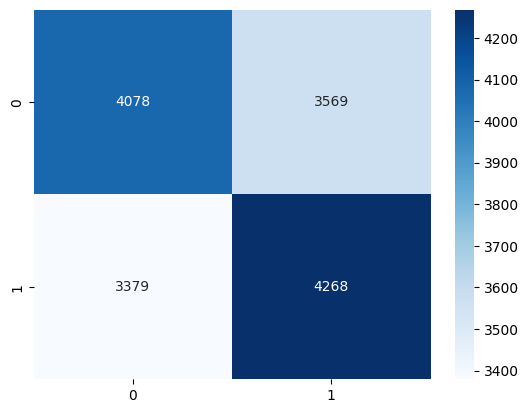

Confusion matrix for the SVC binary classifier:


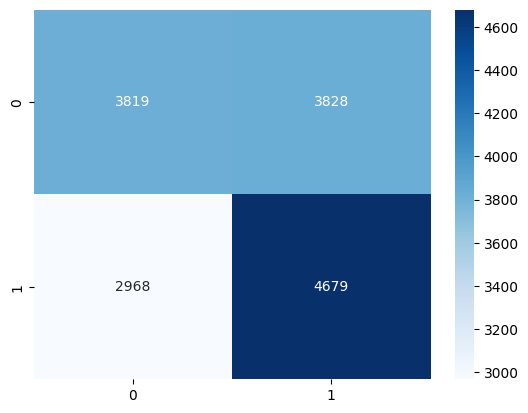

In [21]:
model = MIDbinary()
model.load_state_dict(torch.load("models/binary_model.pt"))
model.eval()

test_values = pd.read_csv("data/values_test.csv")
print(len(test_values[test_values["correct"] == 1]))
print(len(test_values[test_values["correct"] == 0]))
# remove random 2218 rows from the test set where correct = 1
test_values = test_values.drop(test_values[test_values["correct"] == 1].sample(2218).index)

test_dataset_bin = BinaryDataset(test_values)

y_true = []
y_pred = []
for i, _ in enumerate(test_dataset_bin):
    sms, label, _ = test_dataset_bin[i]
    sms = sms.unsqueeze(0)
    output = model(sms)
    output = output.detach().numpy()
    output = np.argmax(output)
    y_true.append(label)
    y_pred.append(output)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
print("Confusion matrix for the DL binary classifier:")
plt.show()

binary_classifier = pickle.load(open("models/svc.pkl", "rb"))
y_true = []
y_pred = []
for i, _ in enumerate(test_dataset_bin):
    sms, label, _ = test_dataset_bin[i]
    sms = sms.unsqueeze(0).detach().numpy()
    sms = pd.DataFrame(sms, columns=["sm0", "sm1", "sm2", "sm3"])
    output = binary_classifier.predict(sms)
    output = output[0]
    y_true.append(label)
    y_pred.append(output)

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
print("Confusion matrix for the SVC binary classifier:")
plt.show()

# Data for the final module

In [11]:
for patient in train_patients:
    print("Number of images for each score for patient", patient)
    result = images_df[images_df["patient_id"] == patient]["score"].value_counts()
    result = result.sort_index()
    print(result)

max_number = 44
selected_df = pd.DataFrame()
for patient in train_patients:
    for score in range(0,4):
        patient_score_df = images_df[(images_df["patient_id"] == patient) & (images_df["score"] == f"{score}")]
        if len(patient_score_df) < max_number:
            selected_df = pd.concat([selected_df, patient_score_df])
        else:
            selected_df = pd.concat([selected_df, patient_score_df.sample(n=max_number, random_state=42)])

print(len(selected_df))
print("Number of images for each score for the selected images")
result = selected_df["score"].value_counts()
result = result.sort_index()
print(result)

paths_df = pd.DataFrame()
for index, row in selected_df.iterrows():
    path = os.path.join("images/", row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png" )
    tmp_df = pd.DataFrame({"path": [path]})
    paths_df = pd.concat([paths_df, tmp_df])

Number of images for each score for patient 1052
0    1026
1    2248
2    2494
3     492
Name: score, dtype: int64
Number of images for each score for patient 1069
0     915
1     522
2     736
3    1212
Name: score, dtype: int64
Number of images for each score for patient 1050
0     317
1     427
2     746
3    1270
Name: score, dtype: int64
Number of images for each score for patient 1017
0    1478
1    1388
2    1256
3     625
Name: score, dtype: int64
Number of images for each score for patient 1048
0    3159
1    1472
2     336
3    1440
Name: score, dtype: int64
Number of images for each score for patient 1067
0      75
1     829
2    1111
3    2245
Name: score, dtype: int64
Number of images for each score for patient 1051
0    375
1    298
2    466
3    100
Name: score, dtype: int64
Number of images for each score for patient 1047
0    543
1    356
2     44
3    208
Name: score, dtype: int64
1408
Number of images for each score for the selected images
0    352
1    352
2    352


In [12]:
for patient in test_patients:
    # print the number of images for each score based on image_df
    print("Number of images for each score for patient", patient)
    result = images_df[images_df["patient_id"] == patient]["score"].value_counts()
    # sort the result by score
    result = result.sort_index()
    print(result)

max_number = 29
selected_df_test = pd.DataFrame()
for patient in test_patients:
    for score in range(0,4):
        # get the images for the patient and score
        patient_score_df = images_df[(images_df["patient_id"] == patient) & (images_df["score"] == f"{score}")]
        # if the number of images is less than 40, select all of them
        if len(patient_score_df) < max_number:
            selected_df_test = pd.concat([selected_df_test, patient_score_df])
        else:
            # select 29 images randomly
            selected_df_test = pd.concat([selected_df_test, patient_score_df.sample(n=max_number, random_state=42)])
print(len(selected_df_test))
# print the number of images for each score based on selected_df
print("Number of images for each score for the selected images")
result = selected_df_test["score"].value_counts()
# sort the result by score
result = result.sort_index()
print(result)

# create a new dataframe using each entry of the selected_df as path
paths_test_df = pd.DataFrame()
for index, row in selected_df_test.iterrows():
    # get the path
    path = os.path.join("images/", row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png" )
    # create a new dataframe with the path
    tmp_df = pd.DataFrame({"path": [path]})
    # add the new dataframe to the values dataframe
    paths_test_df = pd.concat([paths_test_df, tmp_df])

Number of images for each score for patient 1045
0    6198
1      29
2     370
3     402
Name: score, dtype: int64
Number of images for each score for patient 1066
0     210
1     911
2    1707
3     677
Name: score, dtype: int64
Number of images for each score for patient 1068
0     217
1     781
2    3458
3    2552
Name: score, dtype: int64
348
Number of images for each score for the selected images
0    87
1    87
2    87
3    87
Name: score, dtype: int64


# Only **ebmbeddings**

In [ ]:
model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

embeddings = []
predictions = []
embeddings_label = []
colors = []
for i in tqdm(range(len(train_dataset))):
    img, label, paths = train_dataset[i]
    if paths not in paths_df["path"].values:
        continue
    embeddings_label.append(label)
    img = img.to(device)
    img = img.unsqueeze(0)
    output = model.get_embeddings(img)
    embeddings.append(output.cpu().detach().numpy())
    prediction = model(img)
    predicted_label = torch.argmax(prediction).cpu().detach().numpy()
    if predicted_label == label:
        predictions.append(1)
        colors.append("green")
    else:
        predictions.append(0)
        colors.append("red")
embeddings = np.array(embeddings)
embeddings = embeddings.reshape(embeddings.shape[0], embeddings.shape[2])
np.save("data/embeddings.npy", embeddings)
np.save("data/embeddings_label.npy", embeddings_label)

100%|██████████| 30209/30209 [16:44<00:00, 30.07it/s]


In [8]:
n = 15
model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()
# load the embeddings and labels
embeddings = np.load("data/embeddings.npy")
embeddings_label = np.load("data/embeddings_label.npy")
correct_mean = [0 for _ in range(n+1)]
correct_min = [0 for _ in range(n+1)]
correct_max = [0 for _ in range(n+1)]
correct_median = [0 for _ in range(n+1)]
correct_mode = [0 for _ in range(n+1)]
# import cosine distance
from sklearn.metrics.pairwise import cosine_similarity

iterations = 0
for i in tqdm(range(len(test_dataset))):
    # if test_dataset[i][2] not in paths_test_df["path"].values:
    #     continue
    iterations += 1
    emb = model.get_embeddings(test_dataset[i][0].unsqueeze(0).to(device)).cpu().detach().numpy()
    label = test_dataset[i][1]

    for j in range(1,n+1):
        # get the j nearest neighbors with cosine distance
        nearest_points = cosine_similarity(emb, embeddings).argsort()[0][-j:][::-1]
        scores = []
        for point in nearest_points:
            scores.append(embeddings_label[point])
        mean_val = round(np.mean(scores))
        min_val = np.min(scores)
        max_val = np.max(scores)
        median_val = np.median(scores)
        mode_val = max(set(scores), key=scores.count)

        if mean_val == label:
            correct_mean[j] += 1
        if min_val == label:
            correct_min[j] += 1
        if max_val == label:
            correct_max[j] += 1
        if median_val == label:
            correct_median[j] += 1
        if mode_val == label:
            correct_mode[j] += 1

max_i = 0
max_acc = 0
function = ""
for i in range(len(correct_mean)):
    print(f"With {i} neighbors, the accuracy with mean is {correct_mean[i]/iterations*100}%")
    if correct_mean[i]/iterations > max_acc:
        max_acc = correct_mean[i]/iterations
        max_i = i
        function = "mean"
    print(f"With {i} neighbors, the accuracy with min is {correct_min[i]/iterations*100}%")
    if correct_min[i]/iterations > max_acc:
        max_acc = correct_min[i]/iterations
        max_i = i
        function = "min"
    print(f"With {i} neighbors, the accuracy with avg is {correct_max[i]/iterations*100}%")
    if correct_max[i]/iterations > max_acc:
        max_acc = correct_max[i]/iterations
        max_i = i
        function = "max"
    print(f"With {i} neighbors, the accuracy with median is {correct_median[i]/iterations*100}%")
    if correct_median[i]/iterations > max_acc:
        max_acc = correct_median[i]/iterations
        max_i = i
        function = "median"
    print(f"With {i} neighbors, the accuracy with mode is {correct_mode[i]/iterations*100}%")
    if correct_mode[i]/iterations > max_acc:
        max_acc = correct_mode[i]/iterations
        max_i = i
        function = "mode"

print(f"The best accuracy is {max_acc*100}% with {max_i} neighbors and the function {function}")

100%|██████████| 17512/17512 [15:48<00:00, 18.47it/s]

With 0 neighbors, the accuracy with mean is 0.0%
With 0 neighbors, the accuracy with min is 0.0%
With 0 neighbors, the accuracy with avg is 0.0%
With 0 neighbors, the accuracy with median is 0.0%
With 0 neighbors, the accuracy with mode is 0.0%
With 1 neighbors, the accuracy with mean is 55.224988579259936%
With 1 neighbors, the accuracy with min is 55.224988579259936%
With 1 neighbors, the accuracy with avg is 55.224988579259936%
With 1 neighbors, the accuracy with median is 55.224988579259936%
With 1 neighbors, the accuracy with mode is 55.224988579259936%
With 2 neighbors, the accuracy with mean is 54.41982640475103%
With 2 neighbors, the accuracy with min is 56.526952946550935%
With 2 neighbors, the accuracy with avg is 53.79168570123344%
With 2 neighbors, the accuracy with median is 45.928506167199636%
With 2 neighbors, the accuracy with mode is 56.526952946550935%
With 3 neighbors, the accuracy with mean is 52.860895386021014%
With 3 neighbors, the accuracy with min is 55.7788944

# t-SNE **ebmbeddings**

In [ ]:
n = 15
correct_mean = [0 for _ in range(n+1)]
correct_min = [0 for _ in range(n+1)]
correct_max = [0 for _ in range(n+1)]
correct_median = [0 for _ in range(n+1)]
correct_mode = [0 for _ in range(n+1)]


iterations = 0
for i in tqdm(range(len(test_dataset))):
    if test_dataset[i][2] not in paths_test_df["path"].values:
        continue
    iterations += 1
    emb = model.get_embeddings(test_dataset[i][0].unsqueeze(0).to(device)).cpu().detach().numpy()
    label = test_dataset[i][1]
    if i == 0:
        np.append(embeddings, emb, axis=0)
    else:
        embeddings[-1] = emb

    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
    tsne_results = tsne.fit_transform(embeddings)

    distances = np.linalg.norm(tsne_results - tsne_results[-1], axis=1)
    for j in range(2,n+2):
        nearest_points = np.argsort(distances)[:j]
        nearest_points = np.delete(nearest_points, 0)
        scores = []
        for point in nearest_points:
            scores.append(embeddings_label[point])
        mean_val = round(np.mean(scores))
        min_val = np.min(scores)
        max_val = np.max(scores)
        median_val = np.median(scores)
        mode_val = max(set(scores), key=scores.count)

        if mean_val == label:
            correct_mean[j-1] += 1
        if min_val == label:
            correct_min[j-1] += 1
        if max_val == label:
            correct_max[j-1] += 1
        if median_val == label:
            correct_median[j-1] += 1
        if mode_val == label:
            correct_mode[j-1] += 1

max_i = 0
max_acc = 0
function = ""
for i in range(len(correct_mean)):
    print(f"With {i} neighbors, the accuracy with mean is {correct_mean[i]/iterations*100}%")
    if correct_mean[i]/iterations > max_acc:
        max_acc = correct_mean[i]/iterations
        max_i = i
        function = "mean"
    print(f"With {i} neighbors, the accuracy with min is {correct_min[i]/iterations*100}%")
    if correct_min[i]/iterations > max_acc:
        max_acc = correct_min[i]/iterations
        max_i = i
        function = "min"
    print(f"With {i} neighbors, the accuracy with avg is {correct_max[i]/iterations*100}%")
    if correct_max[i]/iterations > max_acc:
        max_acc = correct_max[i]/iterations
        max_i = i
        function = "max"
    print(f"With {i} neighbors, the accuracy with median is {correct_median[i]/iterations*100}%")
    if correct_median[i]/iterations > max_acc:
        max_acc = correct_median[i]/iterations
        max_i = i
        function = "median"
    print(f"With {i} neighbors, the accuracy with mode is {correct_mode[i]/iterations*100}%")
    if correct_mode[i]/iterations > max_acc:
        max_acc = correct_mode[i]/iterations
        max_i = i
        function = "mode"

print(f"The best accuracy is {max_acc*100}% with {max_i} neighbors and the function {function}")

100%|██████████| 17512/17512 [08:55<00:00, 32.68it/s] 

With 0 neighbors, the accuracy with mean is 0.0%
With 0 neighbors, the accuracy with min is 0.0%
With 0 neighbors, the accuracy with avg is 0.0%
With 0 neighbors, the accuracy with median is 0.0%
With 0 neighbors, the accuracy with mode is 0.0%
With 1 neighbors, the accuracy with mean is 45.40229885057471%
With 1 neighbors, the accuracy with min is 45.40229885057471%
With 1 neighbors, the accuracy with avg is 45.40229885057471%
With 1 neighbors, the accuracy with median is 45.40229885057471%
With 1 neighbors, the accuracy with mode is 45.40229885057471%
With 2 neighbors, the accuracy with mean is 40.229885057471265%
With 2 neighbors, the accuracy with min is 43.96551724137931%
With 2 neighbors, the accuracy with avg is 43.96551724137931%
With 2 neighbors, the accuracy with median is 35.63218390804598%
With 2 neighbors, the accuracy with mode is 43.96551724137931%
With 3 neighbors, the accuracy with mean is 41.66666666666667%
With 3 neighbors, the accuracy with min is 46.264367816091955

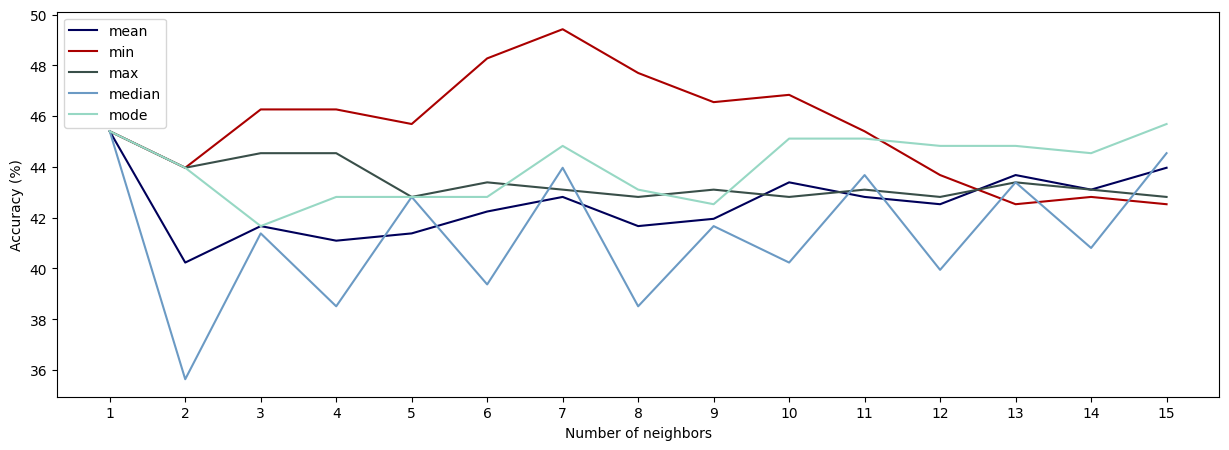

In [ ]:
plt.figure(figsize=(15,5))
colors_val =["#00005A", "#394F49", "#6B9AC4", "#97D8C4"]
new_mean =[i/iterations*100 for i in correct_mean]
new_min =[i/iterations*100 for i in correct_min]
new_max =[i/iterations*100 for i in correct_max]
new_median =[i/iterations*100 for i in correct_median]
new_mode =[i/iterations*100 for i in correct_mode]
plt.plot(range(1,n+1), new_mean[1:], label="mean", color=colors_val[0])
plt.plot(range(1,n+1), new_min[1:], label="min", color="#AA0000")
plt.plot(range(1,n+1), new_max[1:], label="max", color=colors_val[1])
plt.plot(range(1,n+1), new_median[1:], label="median", color=colors_val[2])
plt.plot(range(1,n+1), new_mode[1:], label="mode", color=colors_val[3])
plt.xticks(range(1,n+1))

plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# t-SNE **softmax**

100%|██████████| 348/348 [05:41<00:00,  1.02it/s]

With 0 neighbors, the accuracy with mean is 0.0%
With 0 neighbors, the accuracy with min is 0.0%
With 0 neighbors, the accuracy with avg is 0.0%
With 0 neighbors, the accuracy with median is 0.0%
With 0 neighbors, the accuracy with mode is 0.0%

With 1 neighbors, the accuracy with mean is 48.275862068965516%
With 1 neighbors, the accuracy with min is 48.275862068965516%
With 1 neighbors, the accuracy with avg is 48.275862068965516%
With 1 neighbors, the accuracy with median is 48.275862068965516%
With 1 neighbors, the accuracy with mode is 48.275862068965516%

With 2 neighbors, the accuracy with mean is 47.12643678160919%
With 2 neighbors, the accuracy with min is 47.41379310344828%
With 2 neighbors, the accuracy with avg is 52.29885057471264%
With 2 neighbors, the accuracy with median is 37.06896551724138%
With 2 neighbors, the accuracy with mode is 47.41379310344828%

With 3 neighbors, the accuracy with mean is 52.29885057471264%
With 3 neighbors, the accuracy with min is 44.82758620

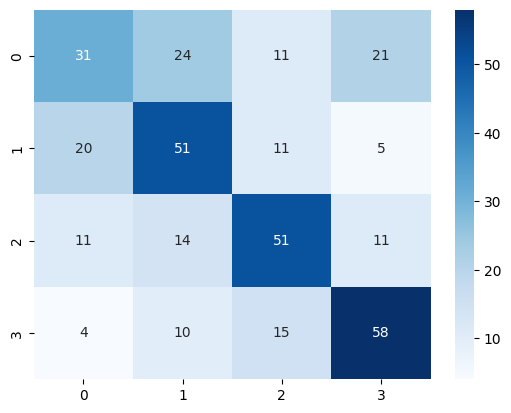

In [20]:

# create the TNSE model (keeping the path information for later)
values = pd.read_csv("data/values_train.csv") #sm0, sm1, sm2, sm3, correct

# remove all raws which path is not in paths_df
values = values[values["path"].isin(paths_df["path"].values)]

colors = ["green" if i == 1 else "red" for i in values["correct"].values]
colors.append("blue")
values_test = pd.read_csv("data/values_test.csv")
values_test = values_test[values_test["path"].isin(paths_test_df["path"].values)]

n = 15
correct_mean = [0 for _ in range(n+1)]
correct_min = [0 for _ in range(n+1)]
correct_max = [0 for _ in range(n+1)]
correct_median = [0 for _ in range(n+1)]
correct_mode = [0 for _ in range(n+1)]

y_true = []
y_pred = []

iterations = 0
for i in tqdm(range(len(values_test))):
    iterations += 1
    if i == 0:
        # values = values.append(values_test.iloc[i], ignore_index=True)
        values = pd.concat([values, values_test.iloc[i:i+1]], ignore_index=True)
    else:
        values.iloc[len(values)-1] = values_test.iloc[i]
    points = values[["sm0", "sm1", "sm2", "sm3"]].values

    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
    tsne_results = tsne.fit_transform(points)

    distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)

    for j in range(2,n+2):
        nearest_points = np.argsort(distances)[:j]
        nearest_points = np.delete(nearest_points, 0)
        
        scores = []
        for k in range(len(nearest_points)):
            scores.append(values.iloc[nearest_points[k]]["true"])
        mean_val = round(np.mean(scores))
        min_val = np.min(scores)
        max_val = np.max(scores)
        median_val = np.median(scores)
        mode_val = max(set(scores), key=scores.count)
        if j == 12:
            y_true.append(values_test.iloc[i]["true"])
            y_pred.append(mode_val)
        if(mean_val == values_test.iloc[i]["true"]):
            correct_mean[j-1] += 1
        if(min_val == values_test.iloc[i]["true"]):
            correct_min[j-1] += 1
        if(max_val == values_test.iloc[i]["true"]):
            correct_max[j-1] += 1
        if(median_val == values_test.iloc[i]["true"]):
            correct_median[j-1] += 1
        if(mode_val == values_test.iloc[i]["true"]):
            correct_mode[j-1] += 1
    del points
    del tsne
    del tsne_results
    del distances
    gc.collect()
max_i = 0
max_acc = 0
function = ""
for i in range(len(correct_mean)):
    print(f"With {i} neighbors, the accuracy with mean is {correct_mean[i]/iterations*100}%")
    if correct_mean[i]/iterations > max_acc:
        max_acc = correct_mean[i]/iterations
        max_i = i
        function = "mean"
    print(f"With {i} neighbors, the accuracy with min is {correct_min[i]/iterations*100}%")
    if correct_min[i]/iterations > max_acc:
        max_acc = correct_min[i]/iterations
        max_i = i
        function = "min"
    print(f"With {i} neighbors, the accuracy with avg is {correct_max[i]/iterations*100}%")
    if correct_max[i]/iterations > max_acc:
        max_acc = correct_max[i]/iterations
        max_i = i
        function = "max"
    print(f"With {i} neighbors, the accuracy with median is {correct_median[i]/iterations*100}%")
    if correct_median[i]/iterations > max_acc:
        max_acc = correct_median[i]/iterations
        max_i = i
        function = "median"

    print(f"With {i} neighbors, the accuracy with mode is {correct_mode[i]/iterations*100}%\n")
    if correct_mode[i]/iterations > max_acc:
        max_acc = correct_mode[i]/iterations
        max_i = i
        function = "mode"

print(f"The best accuracy is {max_acc*100}% with {max_i} neighbors and the function {function}")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

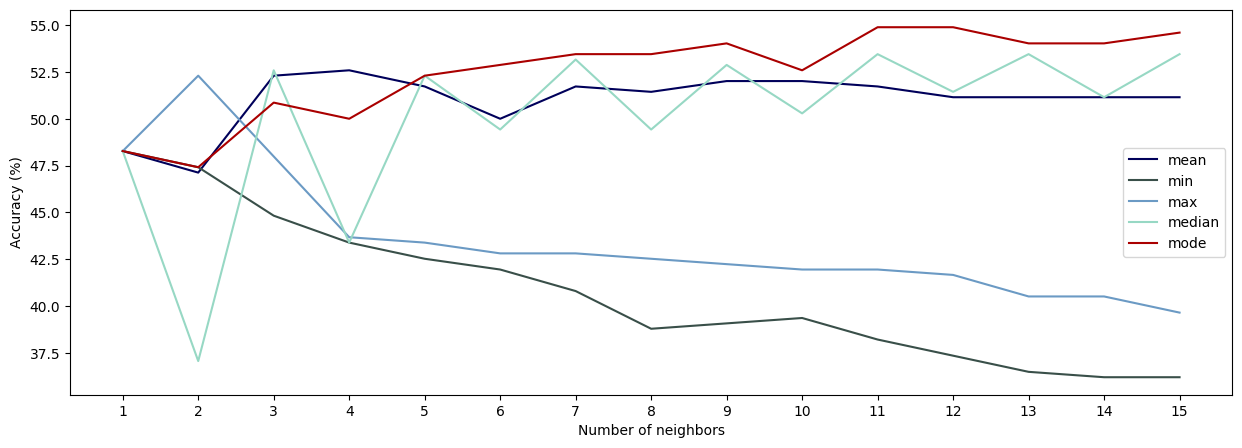

In [74]:
# plot correct_mean, correct_min, correct_max over the number of neighbors
plt.figure(figsize=(15,5))
new_mean =[i/iterations*100 for i in correct_mean]
new_min =[i/iterations*100 for i in correct_min]
new_max =[i/iterations*100 for i in correct_max]
new_median =[i/iterations*100 for i in correct_median]
new_mode =[i/iterations*100 for i in correct_mode]
plt.plot(range(1,n+1), new_mean[1:], label="mean", color=colors_val[0])
plt.plot(range(1,n+1), new_min[1:], label="min", color=colors_val[1])
plt.plot(range(1,n+1), new_max[1:], label="max", color=colors_val[2])
plt.plot(range(1,n+1), new_median[1:], label="median",  color=colors_val[3])
plt.plot(range(1,n+1), new_mode[1:], label="mode", color="#AA0000")
plt.xticks(range(1,n+1))

plt.xlabel("Number of neighbors")	
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# t-SNE to visualize the similar images

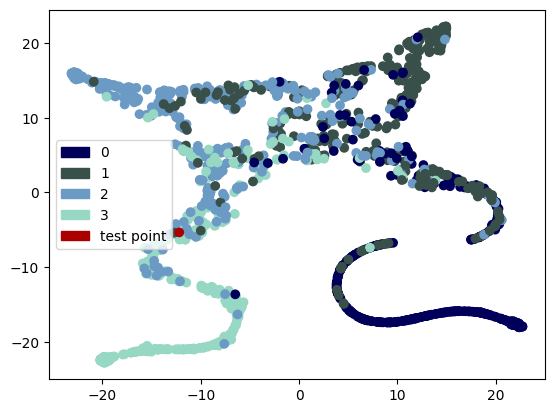

True label of test frame:  3
Predicted label of test frame:  3


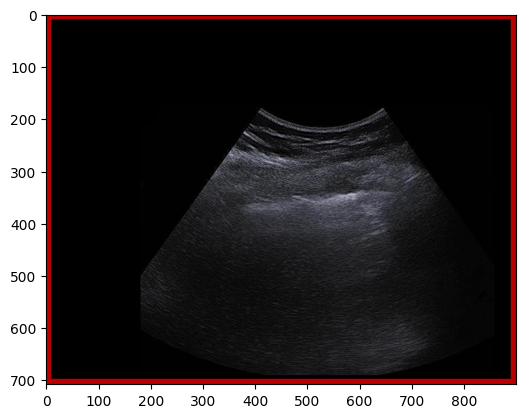

Scores mode: 3


In [72]:
# visual example behavior-wise

# create the TNSE model (keeping the path information for later)
values = pd.read_csv("data/values_train.csv") #sm0, sm1, sm2, sm3, correct
n = 11
# remove all raws which path is not in paths_df
values = values[values["path"].isin(paths_df["path"].values)]
colors = []
for path in values["path"].values:
    if values[values["path"] == path]["true"].values[0] == 0:
        colors.append(colors_val[0])
    elif values[values["path"] == path]["true"].values[0] == 1:
        colors.append(colors_val[1])
    elif values[values["path"] == path]["true"].values[0] == 2:
        colors.append(colors_val[2])
    else:
        colors.append(colors_val[3])

colors.append("#AA0000")
values_test = pd.read_csv("data/values_test.csv")
values_test = values_test[values_test["path"].isin(paths_test_df["path"].values)]
random_index = np.random.randint(0, len(values_test))
# random_query = values_test.iloc[random_index]
# values = pd.concat([values, random_query], ignore_index=True)
values = values.append(values_test.iloc[random_index], ignore_index=True)
points = values[["sm0", "sm1", "sm2", "sm3"]].values
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
tsne_results = tsne.fit_transform(points)

distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)

nearest_points_number = n+1
nearest_points = np.argsort(distances)[:nearest_points_number]
nearest_points = np.delete(nearest_points, 0)


plt.scatter(tsne_results[:,0], tsne_results[:,1], c=colors)
blue_patch = mpatches.Patch(color=colors_val[0] , label='0')
orange_patch = mpatches.Patch(color=colors_val[1], label='1')
green_patch = mpatches.Patch(color=colors_val[2], label='2')
violet_patch = mpatches.Patch(color=colors_val[3], label='3')
red_patch = mpatches.Patch(color="#AA0000", label='test point')
plt.legend(handles=[blue_patch, orange_patch, green_patch, violet_patch, red_patch])
plt.show()

print("True label of test frame: ", test_values.iloc[random_index]["true"])
print("Predicted label of test frame: ", test_values.iloc[random_index]["predicted"])
image = cv2.imread(test_values.iloc[random_index]["path"])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[186, 0, 0])
plt.imshow(image)
plt.show()

scores = []
for i in range(len(nearest_points)):
    # print also the true and predicted label
    scores.append(values.iloc[np.argsort(distances)[i]]["true"])
    # print(f"True label of the {i+1}° nearest image:", values.iloc[np.argsort(distances)[i]]["true"])
    # image = cv2.imread(values.iloc[np.argsort(distances)[i]]["path"])
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # plt.imshow(image)
    # plt.show()
print("Scores mode:", max(set(scores), key=scores.count))


# t-SNE **raw images**

In [54]:
gc.enable()

values = pd.read_csv("data/values_train.csv")

images = []
colors = []
for path in values["path"].values:
    # check if path in paths_df["path"].values
    if path not in paths_df["path"].values:
        continue
    image = cv2.imread(path)
    image = cv2.resize(image, (256, 256)) # Resize the image to a fixed size
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert BGR to RGB
    image = image.astype('float32') / 255.0 # Normalize the pixel values
    images.append(image)
    if values[values["path"] == path]["true"].values[0] == 1:
        colors.append("green")
    else:
        colors.append("red")
    del image

n = 15
correct_mean = [0 for _ in range(n+1)]
correct_min = [0 for _ in range(n+1)]
correct_max = [0 for _ in range(n+1)]
correct_median = [0 for _ in range(n+1)]
correct_mode = [0 for _ in range(n+1)]
test_values = pd.read_csv("data/values_test.csv")

test_values = test_values[test_values["path"].isin(paths_test_df["path"].values)]
iterations = len(test_values["path"].values)
for index in tqdm(range(iterations)):
    new_image = cv2.imread(test_values.iloc[index]["path"])
    new_image = cv2.resize(new_image, (256, 256))
    new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    # new_image = new_image.astype('float32') / 255.0 # Normalize the pixel values
    if(index == 0):
        images.append(new_image)
        colors.append("blue")
        images = np.array(images)
        images_flattened = images.reshape(images.shape[0], -1)
    else:
        new_image = np.array(new_image)
        new_image = new_image.reshape(1, -1)
        images_flattened[len(images_flattened)-1] = new_image

    tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
    tsne_results = tsne.fit_transform(images_flattened)

    distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
    
    for nearest_points_number in range(2,n+2):
        nearest_points = np.argsort(distances)[:nearest_points_number]
        nearest_points = np.delete(nearest_points, 0)
        scores = []
        for i in range(len(nearest_points)):
            scores.append(values.iloc[np.argsort(distances)[i]]["true"])
        mean_val = round(np.mean(scores))
        min_val = np.min(scores)
        max_val = np.max(scores)
        median_val = np.median(scores)
        mode_val = max(set(scores), key=scores.count)
        if(mean_val == int(test_values.iloc[index]["true"])):
            correct_mean[nearest_points_number-1] += 1
        if(min_val == int(test_values.iloc[index]["true"])):
            correct_min[nearest_points_number-1] += 1
        if(max_val == int(test_values.iloc[index]["true"])):
            correct_max[nearest_points_number-1] += 1
        if(median_val == int(test_values.iloc[index]["true"])):
            correct_median[nearest_points_number-1] += 1
        if(mode_val == int(test_values.iloc[index]["true"])):
            correct_mode[nearest_points_number-1] += 1
    if(index == 0):
        del images
    del new_image
    del tsne
    del scores
    del nearest_points
    gc.collect()

max_i = 0
max_acc = 0
function = ""
for i in range(len(correct_mean)):
    print(f"With {i} neighbors, the accuracy with mean is {correct_mean[i]/iterations*100}%")
    if correct_mean[i]/iterations > max_acc:
        max_acc = correct_mean[i]/iterations
        max_i = i
        function = "mean"
    print(f"With {i} neighbors, the accuracy with min is {correct_min[i]/iterations*100}%")
    if correct_min[i]/iterations > max_acc:
        max_acc = correct_min[i]/iterations
        max_i = i
        function = "min"
    print(f"With {i} neighbors, the accuracy with avg is {correct_max[i]/iterations*100}%")
    if correct_max[i]/iterations > max_acc:
        max_acc = correct_max[i]/iterations
        max_i = i
        function = "max"
    print(f"With {i} neighbors, the accuracy with median is {correct_median[i]/iterations*100}%")
    if correct_median[i]/iterations > max_acc:
        max_acc = correct_median[i]/iterations
        max_i = i
        function = "median"
    print(f"With {i} neighbors, the accuracy with mode is {correct_mode[i]/iterations*100}%\n")
    if correct_mode[i]/iterations > max_acc:
        max_acc = correct_mode[i]/iterations
        max_i = i
        function = "mode"

print(f"The best accuracy is {max_acc*100}% with {max_i} neighbors and the function {function}")


100%|██████████| 348/348 [1:18:09<00:00, 13.47s/it]

With 0 neighbors, the accuracy with mean is 0.0%
With 0 neighbors, the accuracy with min is 0.0%
With 0 neighbors, the accuracy with avg is 0.0%
With 0 neighbors, the accuracy with median is 0.0%
With 0 neighbors, the accuracy with mode is 0.0%

With 1 neighbors, the accuracy with mean is 25.0%
With 1 neighbors, the accuracy with min is 25.0%
With 1 neighbors, the accuracy with avg is 25.0%
With 1 neighbors, the accuracy with median is 25.0%
With 1 neighbors, the accuracy with mode is 25.0%

With 2 neighbors, the accuracy with mean is 26.72413793103448%
With 2 neighbors, the accuracy with min is 25.0%
With 2 neighbors, the accuracy with avg is 18.103448275862068%
With 2 neighbors, the accuracy with median is 21.551724137931032%
With 2 neighbors, the accuracy with mode is 25.0%

With 3 neighbors, the accuracy with mean is 26.14942528735632%
With 3 neighbors, the accuracy with min is 25.0%
With 3 neighbors, the accuracy with avg is 18.103448275862068%
With 3 neighbors, the accuracy with 

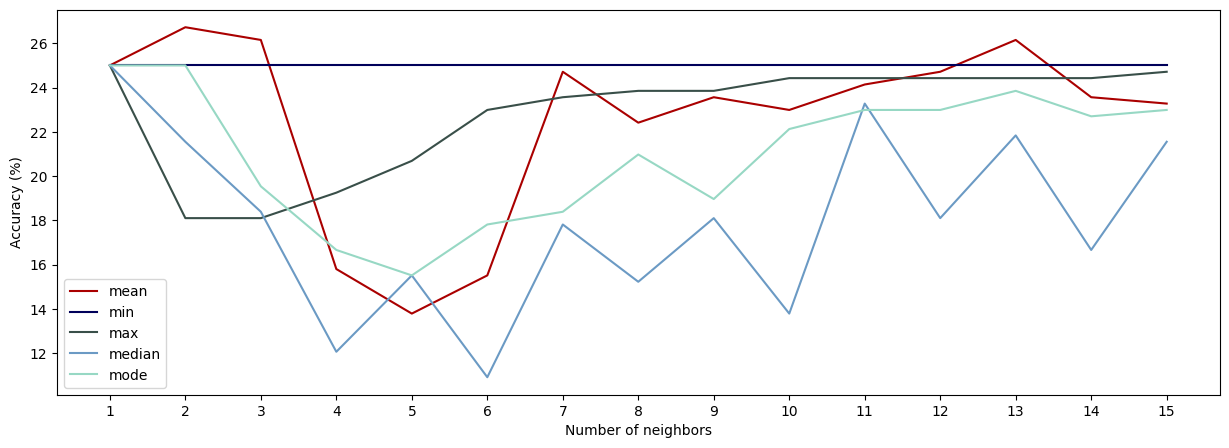

In [71]:
plt.figure(figsize=(15,5))
new_mean =[i/iterations*100 for i in correct_mean]
new_min =[i/iterations*100 for i in correct_min]
new_max =[i/iterations*100 for i in correct_max]
new_median =[i/iterations*100 for i in correct_median]
new_mode =[i/iterations*100 for i in correct_mode]
plt.plot(range(1,n+1), new_mean[1:], label="mean", color="#AA0000")
plt.plot(range(1,n+1), new_min[1:], label="min", color=colors_val[0])
plt.plot(range(1,n+1), new_max[1:], label="max", color=colors_val[1])
plt.plot(range(1,n+1), new_median[1:], label="median", color=colors_val[2])
plt.plot(range(1,n+1), new_mode[1:], label="mode", color=colors_val[3])
plt.xticks(range(1,n+1))

plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.show()

# NEAR-DUPLICATE IMAGE SEARCH

In [11]:
def getPath(row):
    return os.path.join("images/", row["patient_id"] + "_" + row["exam_id"] + "_" + row["spot"] + "_" + row["frame_number"] + "_" + row["score"] + ".png")

Number of features: 512


100%|██████████| 1201/1201 [06:32<00:00,  3.06it/s] 


Correct mean: 213/347 (61.3833%)
Correct min: 202/347 (58.2133%)
Correct max: 195/347 (56.1960%)
Correct median: 213/347 (61.3833%)
Correct mode: 213/347 (61.3833%)
Number of images with no near-duplicates: 854
Best function: mean with accuracy 61.3833%


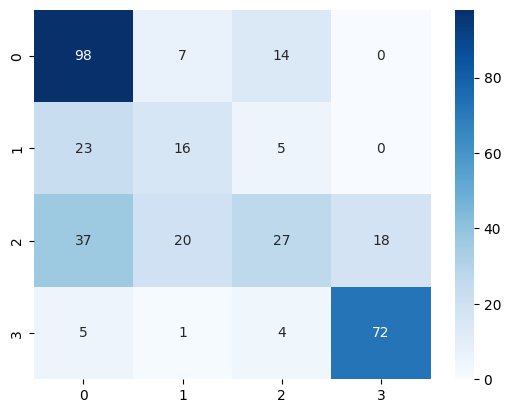

: 

In [22]:
from annoy import AnnoyIndex
gc.enable()
# Load pre-trained model
model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model.to(device)
model.eval()

if not os.path.exists("data/annoy_index.ann"):
    features = []
    for i in tqdm(range(len(train_dataset))):
        image, _, path = train_dataset[i]
        feature = model.get_embeddings(image.unsqueeze(0).to(device))
        features.append(feature.cpu().detach().numpy().squeeze())
        # clear CUDA memory
        del image
        del feature
        torch.cuda.empty_cache()
        gc.collect()
    features = np.array(features)

    # Build an AnnoyIndex
    n_trees = 10  # The number of trees in the index
    n_features = features.shape[1]
else:
    n_features = 512
print(f"Number of features: {n_features}")

annoy_index = AnnoyIndex(n_features, 'angular')

if os.path.exists("data/annoy_index.ann"):
    annoy_index.load("data/annoy_index.ann")
else:
    for i, feature in tqdm(enumerate(features)):
        annoy_index.add_item(i, feature)
    annoy_index.build(n_trees)

# Define a function to search for near-duplicate images
def search_near_duplicates(image, model, threshold=0.5):
    query_feature = model.get_embeddings(image.unsqueeze(0).to(device)).cpu().detach().numpy().squeeze()
    indices, distances = annoy_index.get_nns_by_vector(query_feature, len(train_dataset), include_distances=True)
    near_duplicates = []
    for i, index in enumerate(indices):
        if distances[i] > 0.5:
            break
        _, label, path = train_dataset[index]
        near_duplicates.append((path, label, distances[i]))
    return near_duplicates

def evaluate_model(test_dataset, threshold=0.5, k=5):
    total = 0
    no_near_duplicates = 0
    correct_mean = 0
    correct_min = 0
    correct_max = 0
    correct_median = 0
    correct_mode = 0
    y_true = []
    y_pred = []
    # filter test dataset to keep only images that are in the paths_test_df dataframe
    final_test_dataset = []
    import random
    for x in test_dataset:
        if x[2] in paths_test_df["path"].values:
            final_test_dataset.append(x)
        elif random.random() < 0.05:
            final_test_dataset.append(x)
    # test_dataset = [x for x in test_dataset if x[2] in paths_test_df["path"].values]
    test_dataset = [x for x in final_test_dataset]
    for i in tqdm(range(len(test_dataset))):
        image, label, path = test_dataset[i]
        near_duplicates = search_near_duplicates(image, model)[:k]
        if len(near_duplicates) == 0:
            # print(f"Image {path} has no near-duplicates")
            no_near_duplicates += 1
            continue
        scores = [x[1] for x in near_duplicates]
        avg_score = np.mean(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        median_score = np.median(scores)
        mode_score = max(set(scores), key=scores.count)
        if label == round(avg_score):
            correct_mean += 1
        if label == round(min_score):
            correct_min += 1
        if label == round(max_score):
            correct_max += 1
        if label == round(median_score):
            correct_median += 1
        if label == round(mode_score):
            correct_mode += 1
        total += 1
        y_true.append(label)
        y_pred.append(mode_score)

    print(f"Correct mean: {correct_mean}/{total} ({correct_mean/total*100:.4f}%)")
    print(f"Correct min: {correct_min}/{total} ({correct_min/total*100:.4f}%)")
    print(f"Correct max: {correct_max}/{total} ({correct_max/total*100:.4f}%)")
    print(f"Correct median: {correct_median}/{total} ({correct_median/total*100:.4f}%)")
    print(f"Correct mode: {correct_mode}/{total} ({correct_mode/total*100:.4f}%)")
    best_function_val = max([correct_mean, correct_min, correct_max, correct_median, correct_mode])
    best_function_name = ""
    if best_function_val == correct_mean:
        best_function_name = "mean"
    elif best_function_val == correct_min:
        best_function_name = "min"
    elif best_function_val == correct_max:
        best_function_name = "max"
    elif best_function_val == correct_median:
        best_function_name = "median"
    elif best_function_val == correct_mode:
        best_function_name = "mode"
    print(f"Number of images with no near-duplicates: {no_near_duplicates}")
    return best_function_name, best_function_val/total, confusion_matrix(y_true, y_pred)

name, accuracy, cm = evaluate_model(test_dataset, train_dataset)
print(f"Best function: {name} with accuracy {accuracy*100:.4f}%")
# print the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

In [9]:
# save the annoy index
annoy_index.save("data/annoy_index.ann")

True

# ALL TEST FOR THE FINAL MODEL

In [1]:
# remove warnings
import warnings
warnings.filterwarnings("ignore")

In [9]:
class MIDfinal2(nn.Module):
    def __init__(self, embeddings):
        super(MIDfinal2, self).__init__()
        self.MIDmodel = MIDmodel2()
        self.MIDmodel.load_state_dict(torch.load("models/MIDmodel2.pt"))
        self.MIDmodel.eval()
        # load the binary classifier from binary_model_17.pt
        self.binary_classifier = MIDbinary()
        self.binary_classifier.load_state_dict(torch.load("models/binary_model.pt"))
        self.binary_classifier.eval()
        # self.binary_classifier = pickle.load(open("svc.pkl", "rb"))
        self.embeddings = embeddings

    def forward(self, x):
        # get the output from the MIDmodel
        res = self.MIDmodel(x)
        # get the output from the binary classifier
        predicted_label =torch.nn.functional.softmax(res, dim=1)
        binary_output = self.binary_classifier(predicted_label)
        result = []
        predicted_binary = torch.argmax(binary_output).detach().numpy()
        label_value = torch.argmax(res).detach().numpy()
        result.append(int(predicted_binary))
        result.append(int(label_value))
        # if the binary classifier says FALSE, then we do t-SNE
        if predicted_binary == 0:
            # get the t-SNE output
            res = predicted_label.detach().numpy()
            res = pd.DataFrame(res, columns=["sm0", "sm1", "sm2", "sm3"])
            # values_train = pd.concat([self.values_train, res], axis=1, ignore_index=True)
            values_train = self.values_train.append(res, ignore_index=True)
            points = values_train[["sm0", "sm1", "sm2", "sm3"]].values
            tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
            tsne_results = tsne.fit_transform(points)
            distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
            points_num = 12
            nearest_points = np.argsort(distances)[:points_num]
            nearest_points = np.delete(nearest_points, 0)
            scores = []
            for k in range(len(nearest_points)):
                scores.append(self.values_train.iloc[nearest_points[k]]["true"])
            mode_val = max(set(scores), key=scores.count)
            result.append(int(mode_val))
            return result
        # trasform res to the final label
        res = torch.argmax(res).detach().numpy()
        result.append(int(res))
        return result


In [16]:
class MIDfinal2(nn.Module):
    def __init__(self, values_train):
        super(MIDfinal2, self).__init__()
        self.MIDmodel = MIDmodel2()
        self.MIDmodel.load_state_dict(torch.load("models/MIDmodel2.pt"))
        self.MIDmodel.eval()
        # load the binary classifier from binary_model_17.pt
        self.binary_classifier = MIDbinary()
        self.binary_classifier.load_state_dict(torch.load("models/binary_model.pt"))
        self.binary_classifier.eval()
        # self.binary_classifier = pickle.load(open("svc.pkl", "rb"))
        self.values_train = values_train

    def forward(self, x):
        # get the output from the MIDmodel
        res = self.MIDmodel(x)
        # get the output from the binary classifier
        predicted_label =torch.nn.functional.softmax(res, dim=1)
        binary_output = self.binary_classifier(predicted_label)
        result = []
        predicted_binary = torch.argmax(binary_output).detach().numpy()
        label_value = torch.argmax(res).detach().numpy()
        result.append(int(predicted_binary))
        result.append(int(label_value))
        # if the binary classifier says FALSE, then we do t-SNE
        if predicted_binary == 1:
            # get the t-SNE output
            res = predicted_label.detach().numpy()
            res = pd.DataFrame(res, columns=["sm0", "sm1", "sm2", "sm3"])
            # values_train = pd.concat([self.values_train, res], axis=1, ignore_index=True)
            values_train = self.values_train.append(res, ignore_index=True)
            points = values_train[["sm0", "sm1", "sm2", "sm3"]].values
            tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
            tsne_results = tsne.fit_transform(points)
            distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
            points_num = 12
            nearest_points = np.argsort(distances)[:points_num]
            nearest_points = np.delete(nearest_points, 0)
            scores = []
            for k in range(len(nearest_points)):
                scores.append(self.values_train.iloc[nearest_points[k]]["true"])
            mode_val = max(set(scores), key=scores.count)
            result.append(int(mode_val))
            return result
        # trasform res to the final label
        res = torch.argmax(res).detach().numpy()
        result.append(int(res))
        return result


100%|██████████| 800/800 [06:15<00:00,  2.13it/s]

Accuracy: 489/800 (61.1250%)


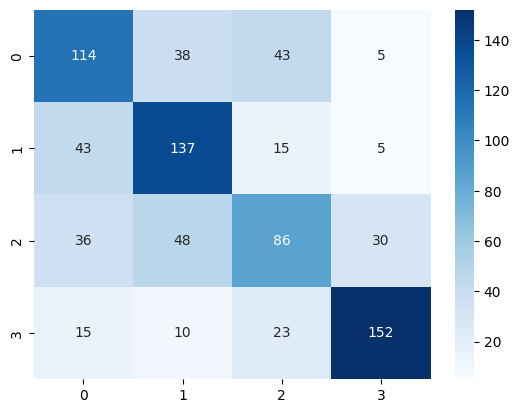

In [18]:
# create the model and test on the test dataset
values = pd.read_csv("data/values_train.csv") #sm0, sm1, sm2, sm3, correct
# remove all raws which path is not in paths_df
values = values[values["path"].isin(paths_df["path"].values)]
model = MIDfinal2(values)
model.eval()
# test the model
test_dataset = ImageDataset("images/", test_patients, test_images_df, transform=None)
correct = 0
total = 0
y_true = []
y_pred = []
for_table = []
for i in tqdm(range(len(test_dataset))):
    image, label, path = test_dataset[i]
    image = image.unsqueeze(0)
    output = model(image)
    binary = output[0]
    resnet = output[1]
    output = output[2]
    if output == label:
        correct += 1
    total += 1
    y_true.append(label)
    y_pred.append(output)
    for_table.append([label, output, binary, resnet])
print(f"Accuracy: {correct}/{total} ({correct/total*100:.4f}%)")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# in for_table we have the following:
# 0 - true label
# 1 - predicted label
# 2 - binary classifier output
# 3 - resnet output
# we want to see for each label the number of times the binary classifier was right

# create a dataframe from for_table
for_table = pd.DataFrame(for_table, columns=["label", "predicted", "binary", "resnet"])
# save the dataframe to csv
for_table.to_csv("for_table.csv", index=False)



In [62]:
# load the for_table dataframe
for_table = pd.read_csv("for_table.csv")
# number of binary=0 when true != predicted and label is 0
binary_0 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 0)].shape[0]
# number of binary=0 when true != predicted and label is 1
binary_1 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 1)].shape[0]
# number of binary=0 when true != predicted and label is 2
binary_2 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 2)].shape[0]
# number of binary=0 when true != predicted and label is 3
binary_3 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 3)].shape[0]

# number of binary=1 when true == predicted and label is 0
binary_4 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 0)].shape[0]
# number of binary=1 when true == predicted and label is 1
binary_5 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 1)].shape[0]
# number of binary=1 when true == predicted and label is 2
binary_6 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 2)].shape[0]
# number of binary=1 when true == predicted and label is 3
binary_7 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 3)].shape[0]

# print everything as a number and as a percentage
print(f"binary=0 when true != predicted and label is 0: {binary_0} ({binary_0/for_table[for_table['label'] == 0].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 1: {binary_1} ({binary_1/for_table[for_table['label'] == 1].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 2: {binary_2} ({binary_2/for_table[for_table['label'] == 2].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 3: {binary_3} ({binary_3/for_table[for_table['label'] == 3].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 0: {binary_4} ({binary_4/for_table[for_table['label'] == 0].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 1: {binary_5} ({binary_5/for_table[for_table['label'] == 1].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 2: {binary_6} ({binary_6/for_table[for_table['label'] == 2].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 3: {binary_7} ({binary_7/for_table[for_table['label'] == 3].shape[0]*100:.4f}%)")


binary=0 when true != predicted and label is 0: 53 (26.5000%)
binary=0 when true != predicted and label is 1: 13 (6.5000%)
binary=0 when true != predicted and label is 2: 87 (43.5000%)
binary=0 when true != predicted and label is 3: 24 (12.0000%)
binary=1 when true == predicted and label is 0: 78 (39.0000%)
binary=1 when true == predicted and label is 1: 14 (7.0000%)
binary=1 when true == predicted and label is 2: 72 (36.0000%)
binary=1 when true == predicted and label is 3: 0 (0.0000%)


In [32]:
class MIDfinal2(nn.Module):
    def __init__(self, values_train):
        super(MIDfinal2, self).__init__()
        self.MIDmodel = MIDmodel2()
        self.MIDmodel.load_state_dict(torch.load("models/MIDmodel2.pt"))
        self.MIDmodel.eval()
        self.binary_classifier0 = pickle.load(open("models/svc0.pkl", "rb"))
        self.binary_classifier1 = pickle.load(open("models/svc1.pkl", "rb"))
        self.binary_classifier2 = pickle.load(open("models/svc2.pkl", "rb"))
        self.binary_classifier3 = pickle.load(open("models/svc3.pkl", "rb"))
        self.values_train = values_train

    def forward(self, x):
        # get the output from the MIDmodel
        res = self.MIDmodel(x)
        # get the output from the binary classifier
        predicted_label =torch.nn.functional.softmax(res, dim=1)
        predicted_label = predicted_label.detach().numpy()
        predicted_label = pd.DataFrame(predicted_label, columns=["sm0", "sm1", "sm2", "sm3"])
        label_value = torch.argmax(res).detach().numpy()
        results = []
        results.append(label_value)
        if label_value == 0:
            binary_output = self.binary_classifier0.predict(predicted_label)
        elif label_value == 1:
            binary_output = self.binary_classifier1.predict(predicted_label)
        elif label_value == 2:
            binary_output = self.binary_classifier2.predict(predicted_label)
        elif label_value == 3:
            binary_output = self.binary_classifier3.predict(predicted_label)
        binary_output = binary_output[0]
        results.append(binary_output)
        # if the binary classifier says FALSE, then we do t-SNE
        if binary_output == 0:
            # get the t-SNE output
            res = predicted_label
            res = pd.DataFrame(res, columns=["sm0", "sm1", "sm2", "sm3"])
            # values_train = pd.concat([self.values_train, res], axis=1, ignore_index=True)
            values_train = self.values_train.append(res, ignore_index=True)
            points = values_train[["sm0", "sm1", "sm2", "sm3"]].values
            tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=400)
            tsne_results = tsne.fit_transform(points)
            distances = np.linalg.norm(tsne_results - tsne_results[len(tsne_results)-1], axis=1)
            points_num = 12
            nearest_points = np.argsort(distances)[:points_num]
            nearest_points = np.delete(nearest_points, 0)
            scores = []
            for k in range(len(nearest_points)):
                scores.append(self.values_train.iloc[nearest_points[k]]["true"])
            mode_val = max(set(scores), key=scores.count)
            results.append(mode_val)
            return results
        # trasform res to the final label
        res = torch.argmax(res).detach().numpy()
        results.append(res)
        return results

100%|██████████| 17512/17512 [1:59:54<00:00,  2.43it/s]  

Accuracy: 9386/17512 (53.5975%)


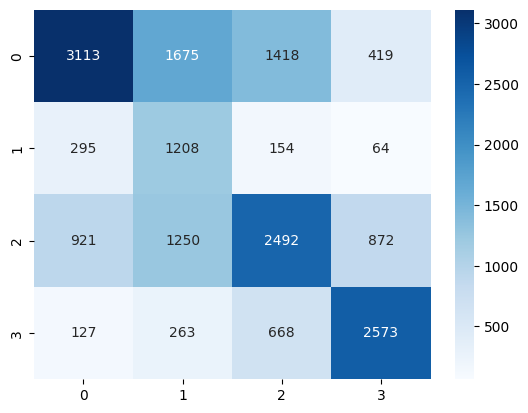

binary=0 when true != predicted and label is 0: 1555 (23.4717%)
binary=0 when true != predicted and label is 1: 396 (23.0099%)
binary=0 when true != predicted and label is 2: 1182 (21.3550%)
binary=0 when true != predicted and label is 3: 814 (22.4181%)
binary=1 when true == predicted and label is 0: 1543 (23.2906%)
binary=1 when true == predicted and label is 1: 959 (55.7234%)
binary=1 when true == predicted and label is 2: 1425 (25.7453%)
binary=1 when true == predicted and label is 3: 1847 (50.8675%)


In [39]:
# create the model and test on the test dataset
values = pd.read_csv("data/values_train.csv") #sm0, sm1, sm2, sm3, correct
# remove all raws which path is not in paths_df
values = values[values["path"].isin(paths_df["path"].values)]
model = MIDfinal2(values)
model.eval()
# test the model
# test_dataset = ImageDataset("images/", test_patients, images_df, transform=None)
correct = 0
total = 0
y_true = []
y_pred = []
results = []
for i in tqdm(range(len(test_dataset))):
    image, label, path = test_dataset[i]
    image = image.unsqueeze(0)
    output = model(image)
    resnet = output[0]
    binary = output[1]
    output = output[2]
    if output == label:
        correct += 1
    total += 1
    y_true.append(label)
    y_pred.append(output)
    results.append([label, resnet, binary, output])
print(f"Accuracy: {correct}/{total} ({correct/total*100:.4f}%)")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# create the table
for_table = pd.DataFrame(results, columns=["label", "resnet", "binary", "predicted"])

binary_0 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 0)].shape[0]
# number of binary=0 when true != predicted and label is 1
binary_1 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 1)].shape[0]
# number of binary=0 when true != predicted and label is 2
binary_2 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 2)].shape[0]
# number of binary=0 when true != predicted and label is 3
binary_3 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 3)].shape[0]

# number of binary=1 when true == predicted and label is 0
binary_4 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 0)].shape[0]
# number of binary=1 when true == predicted and label is 1
binary_5 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 1)].shape[0]
# number of binary=1 when true == predicted and label is 2
binary_6 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 2)].shape[0]
# number of binary=1 when true == predicted and label is 3
binary_7 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 3)].shape[0]

# print everything as a number and as a percentage
print(f"binary=0 when true != predicted and label is 0: {binary_0} ({binary_0/for_table[for_table['label'] == 0].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 1: {binary_1} ({binary_1/for_table[for_table['label'] == 1].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 2: {binary_2} ({binary_2/for_table[for_table['label'] == 2].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 3: {binary_3} ({binary_3/for_table[for_table['label'] == 3].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 0: {binary_4} ({binary_4/for_table[for_table['label'] == 0].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 1: {binary_5} ({binary_5/for_table[for_table['label'] == 1].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 2: {binary_6} ({binary_6/for_table[for_table['label'] == 2].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 3: {binary_7} ({binary_7/for_table[for_table['label'] == 3].shape[0]*100:.4f}%)")



100%|██████████| 17512/17512 [04:05<00:00, 71.21it/s]


Accuracy: 9865/17512 (56.3328%)


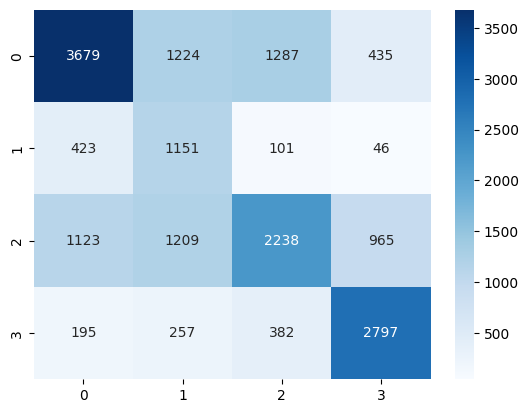

In [13]:
# load MIDmodel2
model = MIDmodel2()
model.load_state_dict(torch.load("models/MIDmodel2.pt"))
model = model.to(device)
model.eval()

correct = 0
total = 0
y_true = []
y_pred = []
for i in tqdm(range(len(test_dataset))):
    image, label, path = test_dataset[i]
    image = image.unsqueeze(0)
    image = image.to(device)
    output = model(image)
    if torch.argmax(output) == label:
        correct += 1
    total += 1
    y_true.append(label)
    y_pred.append(torch.argmax(output).cpu().detach().numpy())
print(f"Accuracy: {correct}/{total} ({correct/total*100:.4f}%)")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

In [17]:
class MIDfinal2(nn.Module):
    def __init__(self, embeddings, embeddings_labels):
        super(MIDfinal2, self).__init__()
        self.MIDmodel = MIDmodel2()
        self.MIDmodel.load_state_dict(torch.load("models/MIDmodel2.pt"))
        self.MIDmodel.eval()
        # load the binary classifier from binary_model_17.pt
        self.binary_classifier = MIDbinary()
        self.binary_classifier.load_state_dict(torch.load("models/binary_model.pt"))
        self.binary_classifier.eval()
        # self.binary_classifier = pickle.load(open("svc.pkl", "rb"))
        self.embeddings = embeddings
        self.embeddings_labels = embeddings_labels

    def forward(self, x):
        # get the output from the MIDmodel
        res = self.MIDmodel(x)
        # get the output from the binary classifier
        predicted_label =torch.nn.functional.softmax(res, dim=1)
        binary_output = self.binary_classifier(predicted_label)
        result = []
        predicted_binary = torch.argmax(binary_output).detach().numpy()
        label_value = torch.argmax(res).detach().numpy()
        result.append(int(predicted_binary))
        result.append(int(label_value))

        if predicted_binary == 0:
            emb = self.MIDmodel.get_embeddings(x).detach().numpy()
            points_num = 14
            nearest_points = cosine_similarity(emb, embeddings).argsort()[0][-points_num:][::-1]
            scores = []
            for k in range(len(nearest_points)):
                scores.append(embeddings_label[point])
            mode_val = max(set(scores), key=scores.count)
            result.append(int(mode_val))
            return result
        # trasform res to the final label
        res = torch.argmax(res).detach().numpy()
        result.append(int(res))
        return result


100%|██████████| 17512/17512 [13:48<00:00, 21.13it/s]

Accuracy: 6736/17512 (38.4651%)


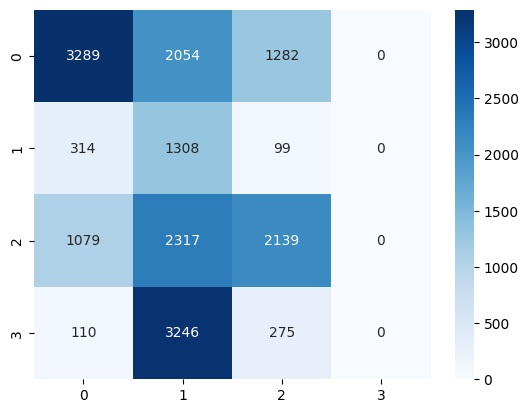

binary=0 when true != predicted and label is 0: 397 (5.9925%)
binary=0 when true != predicted and label is 1: 314 (18.2452%)
binary=0 when true != predicted and label is 2: 1125 (20.3252%)
binary=0 when true != predicted and label is 3: 196 (5.3980%)
binary=1 when true == predicted and label is 0: 0 (0.0000%)
binary=1 when true == predicted and label is 1: 1150 (66.8216%)
binary=1 when true == predicted and label is 2: 0 (0.0000%)
binary=1 when true == predicted and label is 3: 0 (0.0000%)


In [18]:
# create the model and test on the test dataset
# values = pd.read_csv("data/values_train.csv") #sm0, sm1, sm2, sm3, correct
# remove all raws which path is not in paths_df
# values = values[values["path"].isin(paths_df["path"].values)]
embeddings = np.load("data/embeddings.npy")
embeddings_label = np.load("data/embeddings_label.npy")
model = MIDfinal2(embeddings, embeddings_label)
model.eval()

# test the model
# test_dataset = ImageDataset("images/", test_patients, images_df, transform=None)
correct = 0
total = 0
y_true = []
y_pred = []
results = []
for i in tqdm(range(len(test_dataset))):
    image, label, path = test_dataset[i]
    image = image.unsqueeze(0)
    output = model(image)
    resnet = output[0]
    binary = output[1]
    output = output[2]
    if output == label:
        correct += 1
    total += 1
    y_true.append(label)
    y_pred.append(output)
    results.append([label, resnet, binary, output])
print(f"Accuracy: {correct}/{total} ({correct/total*100:.4f}%)")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# create the table
for_table = pd.DataFrame(results, columns=["label", "resnet", "binary", "predicted"])

binary_0 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 0)].shape[0]
# number of binary=0 when true != predicted and label is 1
binary_1 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 1)].shape[0]
# number of binary=0 when true != predicted and label is 2
binary_2 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 2)].shape[0]
# number of binary=0 when true != predicted and label is 3
binary_3 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 3)].shape[0]

# number of binary=1 when true == predicted and label is 0
binary_4 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 0)].shape[0]
# number of binary=1 when true == predicted and label is 1
binary_5 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 1)].shape[0]
# number of binary=1 when true == predicted and label is 2
binary_6 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 2)].shape[0]
# number of binary=1 when true == predicted and label is 3
binary_7 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 3)].shape[0]

# print everything as a number and as a percentage
print(f"binary=0 when true != predicted and label is 0: {binary_0} ({binary_0/for_table[for_table['label'] == 0].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 1: {binary_1} ({binary_1/for_table[for_table['label'] == 1].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 2: {binary_2} ({binary_2/for_table[for_table['label'] == 2].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 3: {binary_3} ({binary_3/for_table[for_table['label'] == 3].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 0: {binary_4} ({binary_4/for_table[for_table['label'] == 0].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 1: {binary_5} ({binary_5/for_table[for_table['label'] == 1].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 2: {binary_6} ({binary_6/for_table[for_table['label'] == 2].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 3: {binary_7} ({binary_7/for_table[for_table['label'] == 3].shape[0]*100:.4f}%)")



In [29]:
def search_near_duplicates(image, model, threshold=0.5):
    query_feature = model.get_embeddings(image).detach().numpy().squeeze()
    indices, distances = annoy_index.get_nns_by_vector(query_feature, len(train_dataset), include_distances=True)
    near_duplicates = []
    for i, index in enumerate(indices):
        if distances[i] > 0.5:
            break
        _, label, path = train_dataset[index]
        near_duplicates.append((path, label, distances[i]))
    return near_duplicates

class MIDfinal2(nn.Module):
    def __init__(self, annoy_index):
        super(MIDfinal2, self).__init__()
        self.MIDmodel = MIDmodel2()
        self.MIDmodel.load_state_dict(torch.load("models/MIDmodel2.pt"))
        self.MIDmodel.eval()
        self.binary_classifier = MIDbinary()
        self.binary_classifier.load_state_dict(torch.load("models/binary_model.pt"))
        self.binary_classifier.eval()
        self.annoy_index = annoy_index

    def forward(self, x):
        # get the output from the MIDmodel
        res = self.MIDmodel(x)
        # get the output from the binary classifier
        predicted_label =torch.nn.functional.softmax(res, dim=1)
        binary_output = self.binary_classifier(predicted_label)
        result = []
        predicted_binary = torch.argmax(binary_output).detach().numpy()
        label_value = torch.argmax(res).detach().numpy()
        result.append(int(predicted_binary))
        result.append(int(label_value))

        if predicted_binary == 0:
            near_duplicates = search_near_duplicates(x, self.MIDmodel)[:5]
            if len(near_duplicates) > 0:
                scores = [x[1] for x in near_duplicates]
                mode_val = max(set(scores), key=scores.count)
                result.append(int(mode_val))
                return result
        # trasform res to the final label
        res = torch.argmax(res).detach().numpy()
        result.append(int(res))
        return result


100%|██████████| 17512/17512 [38:32<00:00,  7.57it/s]  


Accuracy: 9979/17512 (56.9838%)


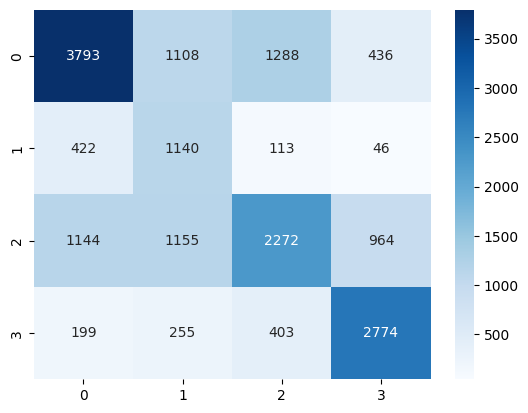

binary=0 when true != predicted and label is 0: 23 (0.3472%)
binary=0 when true != predicted and label is 1: 417 (24.2301%)
binary=0 when true != predicted and label is 2: 1125 (20.3252%)
binary=0 when true != predicted and label is 3: 196 (5.3980%)
binary=1 when true == predicted and label is 0: 130 (1.9623%)
binary=1 when true == predicted and label is 1: 1133 (65.8338%)
binary=1 when true == predicted and label is 2: 35 (0.6323%)
binary=1 when true == predicted and label is 3: 0 (0.0000%)


In [30]:
annoy_index = AnnoyIndex(512, 'angular')
annoy_index.load("data/annoy_index.ann")

model = MIDfinal2(annoy_index)
model.eval()

# test the model
# test_dataset = ImageDataset("images/", test_patients, images_df, transform=None)
correct = 0
total = 0
y_true = []
y_pred = []
results = []
for i in tqdm(range(len(test_dataset))):
    image, label, path = test_dataset[i]
    image = image.unsqueeze(0)
    output = model(image)
    resnet = output[0]
    binary = output[1]
    output = output[2]
    if output == label:
        correct += 1
    total += 1
    y_true.append(label)
    y_pred.append(output)
    results.append([label, resnet, binary, output])
print(f"Accuracy: {correct}/{total} ({correct/total*100:.4f}%)")

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.show()

# create the table
for_table = pd.DataFrame(results, columns=["label", "resnet", "binary", "predicted"])

binary_0 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 0)].shape[0]
# number of binary=0 when true != predicted and label is 1
binary_1 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 1)].shape[0]
# number of binary=0 when true != predicted and label is 2
binary_2 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 2)].shape[0]
# number of binary=0 when true != predicted and label is 3
binary_3 = for_table[(for_table["binary"] == 0) & (for_table["label"] != for_table["predicted"]) & (for_table["label"] == 3)].shape[0]

# number of binary=1 when true == predicted and label is 0
binary_4 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 0)].shape[0]
# number of binary=1 when true == predicted and label is 1
binary_5 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 1)].shape[0]
# number of binary=1 when true == predicted and label is 2
binary_6 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 2)].shape[0]
# number of binary=1 when true == predicted and label is 3
binary_7 = for_table[(for_table["binary"] == 1) & (for_table["label"] == for_table["predicted"]) & (for_table["label"] == 3)].shape[0]

# print everything as a number and as a percentage
print(f"binary=0 when true != predicted and label is 0: {binary_0} ({binary_0/for_table[for_table['label'] == 0].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 1: {binary_1} ({binary_1/for_table[for_table['label'] == 1].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 2: {binary_2} ({binary_2/for_table[for_table['label'] == 2].shape[0]*100:.4f}%)")
print(f"binary=0 when true != predicted and label is 3: {binary_3} ({binary_3/for_table[for_table['label'] == 3].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 0: {binary_4} ({binary_4/for_table[for_table['label'] == 0].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 1: {binary_5} ({binary_5/for_table[for_table['label'] == 1].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 2: {binary_6} ({binary_6/for_table[for_table['label'] == 2].shape[0]*100:.4f}%)")
print(f"binary=1 when true == predicted and label is 3: {binary_7} ({binary_7/for_table[for_table['label'] == 3].shape[0]*100:.4f}%)")

